# **画像分類器を訓練する**


## 0. Setup

Colabのマウント

In [4]:
import torch
import torchvision
torch.__version__, torchvision.__version__

('1.8.1+cu101', '0.9.1+cu101')

In [7]:
!pip list

Package                       Version            
----------------------------- -------------------
absl-py                       0.12.0             
alabaster                     0.7.12             
albumentations                0.1.12             
altair                        4.1.0              
appdirs                       1.4.4              
argon2-cffi                   20.1.0             
arviz                         0.11.2             
astor                         0.8.1              
astropy                       4.2.1              
astunparse                    1.6.3              
async-generator               1.10               
atari-py                      0.2.9              
atomicwrites                  1.4.0              
attrs                         21.2.0             
audioread                     2.1.9              
autograd                      1.3                
Babel                         2.9.1              
backcall                      0.2.0              


In [ ]:
from google.colab import drive # driveを接続
drive.mount('/content/drive')

# drive中の課題ファイルのあるディレクトリに移動
%cd /content/drive/MyDrive/先端人工知能論Ⅰ/FAI20210601

Mounted at /content/drive
/content/drive/MyDrive/先端人工知能論Ⅰ/FAI20210601


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split

データのダウンロード，正規化，Tensorへの変換

In [ ]:
#変換器の作成
#transforms.Composeによって複数の変換を組み合わせ、データを読み込む際に使用するデータ変換器を作成します．
#ここではPILImageをtorch.Tensorに変換したのち正規化を行う変換器を作成します．
transform = transforms.Compose(
    [transforms.ToTensor(),  # torch.Tensor へ変換
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 正規化する
 
#訓練データのダウンロードと変換
#扱うデータの集合であるデータセットを作成します．
#データは読み込まれる際に変換器によって変換され取り出されます．
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#訓練データのローダ(読み込み器)の作成
#データセットからデータを読み込むローダを作成します．
#ローダを挟むことで同時に幾つのデータを読み込むか、順番に読み込むかランダムに読み込むかなどデータの読み込み方を容易に設定できます．
#またnum_workersの指定によってデータ読み込みの並列化を容易に実現できます．
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
 
#テストデータのダウンロードと変換
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
#テストデータのローダ(読み込み器)の作成
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 学習

### 評価用関数

In [ ]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=1000):
    super(self.__class__, self).__init__()
    self.num_classes = num_classes

    self.relu = F.relu
    self.pool = nn.MaxPool2d(2)
    
    self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)

    self.fc1 = nn.Linear(256 * 4 * 4, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, num_classes)
 
  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = self.relu(x)
    x = self.conv4(x)
    x = self.relu(x)
    x = self.conv5(x)
    x = self.relu(x)
    x = self.pool(x)
    x = x.view(-1, self.num_flat_features(x))
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x
 
  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

class Net(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)   # 入力のチャネル数は1，出力のチャネル数は6，5x5の畳み込み層
        self.conv2 = nn.Conv2d(6, 16, 5)  # 入力のチャネル数は6，出力のチャネル数は16，5x5の畳み込み層
        
        # 線形層 y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)   
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))   # 大きさ(2,2)のMaxプーリング層
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)    # プーリングのWindowサイズの縦と横が同じ大きさなら，タプルではなく単一の値で指定できる
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]   # バッチの次元以外のすべての次元
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
def train(model, criterion, optimizer, epochs, device="cuda:0", 
          verbose=True, minibatch=2000):
    model = model.to(device)
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if verbose:
                running_loss += loss.item()
                if i % minibatch == minibatch-1:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / minibatch))
                    running_loss = 0.0

    print('Finished Training')

    return model

def test(model, device="cuda:0"):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {correct / total * 100:.2f} %')

In [ ]:
def cross_validation(modelclass, modelparams,
                     critclass, critparams,
                     optimclass, optimparams, 
                     batch_size=4, epoch_size=5, 
                     repsize=3, validsize=0.2, modelname="", 
                     random_state=42, repstart=0,
                     device="cuda:0", verbose=True, verbose_interval="auto"):
  if verbose_interval=="auto":
    verbose_interval = 40000 // batch_size // 5
  # Hold-out を r 回
  scoresss = []
  for r in range(repstart, repsize):
    print(f"loop {r+1}")
    learn_index, valid_index = train_test_split(
        range(len(trainset)),
        test_size=validsize, random_state=random_state+r)
    learn_dataset = Subset(trainset, learn_index)
    learn_dataloader = DataLoader(learn_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=2)
    valid_dataset = Subset(trainset, valid_index)
    valid_dataloader = DataLoader(valid_dataset,
                                  shuffle=False, num_workers=2)

    model = modelclass(**modelparams)
    model = model.to(device)
    criterion = critclass(**critparams)
    optimizer = optimclass(model.parameters(), **optimparams)

    scoress = []
    for epoch in range(epoch_size):
      # 学習
      print(f"  epoch {epoch+1} | ", end="")

      learn_loss = 0.0
      learn_correct = 0
      learn_total = 0
      scores = []
      for i, data in enumerate(learn_dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        learn_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        learn_correct += (predicted == labels).sum().item()
        learn_total += labels.size(0)

        if i % verbose_interval == verbose_interval-1:
          print('\n    [%d, %5d] loss: %.4f, acc: %.4f' % # [epoch_count, sample_count]
                (epoch + 1, batch_size * (i + 1), learn_loss / verbose_interval, learn_correct / learn_total),
                end="")
          scores += [[learn_loss/verbose_interval, learn_correct/learn_total]]
          learn_loss = 0.0
          learn_correct = 0
          learn_total = 0
      
      # バリデーション
      with torch.no_grad():
        valid_loss = 0.0
        valid_correct = 0
        valid_total = 0
        for data in valid_dataloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          valid_correct += (predicted == labels).sum().item()
          valid_total += labels.size(0)
          valid_loss += criterion(outputs, labels).item()
      scores += [[valid_loss/valid_total, valid_correct/valid_total]]
      print(f' | validation loss: {valid_loss / valid_total:.4f}, acc: {valid_correct / valid_total:.4f}')
      scoress += [scores]
    scoresss += [scoress]
    torch.save(model.state_dict(), f"./{modelname}_{r}.pth")
  # [[learn_loss, learn_acc] * minibatch , [valid_loss, valid_acc]] * epoch * loop
  return scoresss


In [ ]:
from torchsummary import summary
model = Net()
#model = model.to("cuda:0")
summary(model, (3, 32, 32))
model = AlexNet(10)
#model = model.to("cuda:0")
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,688
         MaxPool2d-2           [-1, 96, 16,

In [ ]:
def plot_learning_curve(scoresss):
  s0, s1, s2, s3 = scoresss.shape
  plt.plot(np.arange(0, s1, 1/(s2-1))+1/(s2-1), scoresss[:,:,:-1,0].mean(axis=0).ravel(), 
           marker="o", color="C0", label="learning curve")
  plt.fill_between(np.arange(0, s1, 1/(s2-1))+1/(s2-1),
                  scoresss[:,:,:-1,0].mean(axis=0).ravel()-scoresss[:,:,:-1,0].std(axis=0).ravel()*2,
                  scoresss[:,:,:-1,0].mean(axis=0).ravel()+scoresss[:,:,:-1,0].std(axis=0).ravel()*2,
                  color="C0", alpha=0.4)
  plt.plot(np.arange(0, s1, 1)+1, scoresss[:,:,-1,0].mean(axis=0),
           marker="o", color="C1", label="validaiton curve")
  plt.fill_between(np.arange(0, s1, 1)+1,
                  scoresss[:,:,-1,0].mean(axis=0)-scoresss[:,:,-1,0].std(axis=0)*2,
                  scoresss[:,:,-1,0].mean(axis=0)+scoresss[:,:,-1,0].std(axis=0)*2,
                  color="C1", alpha=0.4)
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  plt.plot(np.arange(0, s1, 1/(s2-1))+1/(s2-1), scoresss[:,:,:-1,1].mean(axis=0).ravel(),
           marker="o", color="C0", label="learning curve")
  plt.fill_between(np.arange(0, s1, 1/(s2-1))+1/(s2-1),
                  scoresss[:,:,:-1,1].mean(axis=0).ravel()-scoresss[:,:,:-1,1].std(axis=0).ravel()*2,
                  scoresss[:,:,:-1,1].mean(axis=0).ravel()+scoresss[:,:,:-1,1].std(axis=0).ravel()*2,
                  color="C0", alpha=0.4)
  plt.plot(np.arange(0, s1, 1)+1, scoresss[:,:,-1,1].mean(axis=0),
           marker="o", color="C1", label="validaiton curve")
  plt.fill_between(np.arange(0, s1, 1)+1,
                  scoresss[:,:,-1,1].mean(axis=0)-scoresss[:,:,-1,1].std(axis=0)*2,
                  scoresss[:,:,-1,1].mean(axis=0)+scoresss[:,:,-1,1].std(axis=0)*2,
                  color="C1", alpha=0.4)
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend()
  plt.show()

In [ ]:
def calc_validation_curve(modelclass, modelparams,
                          critclass, critparams,
                          optimclass, optimparams, 
                          batch_size=4, epoch_size=5, 
                          repsize=3, validsize=0.2, modelname="", 
                          random_state=42, repstart=0,
                          device="cuda:0", verbose=True, verbose_interval="auto"):
  

  s0, s1, s2, s3 = scoresss.shape
  plt.plot(np.arange(0, s1, 1/(s2-1))+1/(s2-1), scoresss[:,:,:-1,0].mean(axis=0).ravel(), 
           marker="o", color="C0", label="learning curve")
  plt.fill_between(np.arange(0, s1, 1/(s2-1))+1/(s2-1),
                  scoresss[:,:,:-1,0].mean(axis=0).ravel()-scoresss[:,:,:-1,0].std(axis=0).ravel()*2,
                  scoresss[:,:,:-1,0].mean(axis=0).ravel()+scoresss[:,:,:-1,0].std(axis=0).ravel()*2,
                  color="C0", alpha=0.4)
  plt.plot(np.arange(0, s1, 1)+1, scoresss[:,:,-1,0].mean(axis=0),
           marker="o", color="C1", label="validaiton curve")
  plt.fill_between(np.arange(0, s1, 1)+1,
                  scoresss[:,:,-1,0].mean(axis=0)-scoresss[:,:,-1,0].std(axis=0)*2,
                  scoresss[:,:,-1,0].mean(axis=0)+scoresss[:,:,-1,0].std(axis=0)*2,
                  color="C1", alpha=0.4)
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  plt.plot(np.arange(0, s1, 1/(s2-1))+1/(s2-1), scoresss[:,:,:-1,1].mean(axis=0).ravel(),
           marker="o", color="C0", label="learning curve")
  plt.fill_between(np.arange(0, s1, 1/(s2-1))+1/(s2-1),
                  scoresss[:,:,:-1,1].mean(axis=0).ravel()-scoresss[:,:,:-1,1].std(axis=0).ravel()*2,
                  scoresss[:,:,:-1,1].mean(axis=0).ravel()+scoresss[:,:,:-1,1].std(axis=0).ravel()*2,
                  color="C0", alpha=0.4)
  plt.plot(np.arange(0, s1, 1)+1, scoresss[:,:,-1,1].mean(axis=0),
           marker="o", color="C1", label="validaiton curve")
  plt.fill_between(np.arange(0, s1, 1)+1,
                  scoresss[:,:,-1,1].mean(axis=0)-scoresss[:,:,-1,1].std(axis=0)*2,
                  scoresss[:,:,-1,1].mean(axis=0)+scoresss[:,:,-1,1].std(axis=0)*2,
                  color="C1", alpha=0.4)
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend()
  plt.show()

### 実行

#### LeNet, CEL, SGD, lr=0.001, momentum=0.9, batch=32

In [ ]:
scoresss = cross_validation(Net, {},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.001, "momentum":0.9},
                 batch_size=32, epoch_size=5, repsize=3,
                 random_state=42, modelname="test", device="cuda:0")

loop 1
  epoch 1 | 
    [1,  8000] loss: 2.3026, acc: 0.0974
    [1, 16000] loss: 2.2993, acc: 0.0975
    [1, 24000] loss: 2.2917, acc: 0.1364
    [1, 32000] loss: 2.2673, acc: 0.1675
    [1, 40000] loss: 2.1842, acc: 0.1878 | validation loss: 2.1085, acc: 0.2132
  epoch 2 | 
    [2,  8000] loss: 2.0571, acc: 0.2560
    [2, 16000] loss: 1.9510, acc: 0.2938
    [2, 24000] loss: 1.8457, acc: 0.3230
    [2, 32000] loss: 1.8021, acc: 0.3299
    [2, 40000] loss: 1.7589, acc: 0.3476 | validation loss: 1.7322, acc: 0.3549
  epoch 3 | 
    [3,  8000] loss: 1.7383, acc: 0.3553
    [3, 16000] loss: 1.7039, acc: 0.3733
    [3, 24000] loss: 1.6409, acc: 0.3951
    [3, 32000] loss: 1.6135, acc: 0.4014
    [3, 40000] loss: 1.5927, acc: 0.4095 | validation loss: 1.5765, acc: 0.4209
  epoch 4 | 
    [4,  8000] loss: 1.5703, acc: 0.4291
    [4, 16000] loss: 1.5226, acc: 0.4371
    [4, 24000] loss: 1.5198, acc: 0.4491
    [4, 32000] loss: 1.4879, acc: 0.4585
    [4, 40000] loss: 1.4815, acc: 0.4636 | va

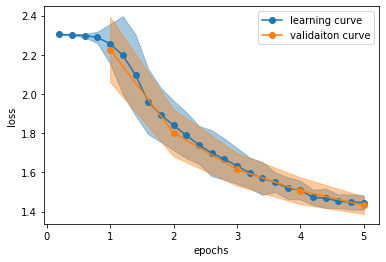

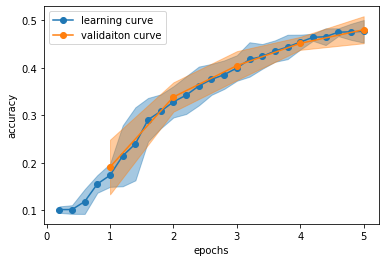

In [ ]:
np.save("Net_CEL.npy", np.array(scoresss))
plot_validation_curve(np.array(scoresss))

#### AlexNet, CEL, SGD, lr=0.001, momentum=0.9, batch=32

loop 1
  epoch 1 | 
    [1,  8000] loss: 6.6906, acc: 0.0954
    [1, 16000] loss: 2.4449, acc: 0.1120
    [1, 24000] loss: 2.2530, acc: 0.1568
    [1, 32000] loss: 2.1640, acc: 0.1961
    [1, 40000] loss: 2.0538, acc: 0.2266 | validation loss: 2.0137, acc: 0.2503
  epoch 2 | 
    [2,  8000] loss: 1.9678, acc: 0.2444
    [2, 16000] loss: 1.8910, acc: 0.2692
    [2, 24000] loss: 1.8293, acc: 0.2944
    [2, 32000] loss: 1.7876, acc: 0.3142
    [2, 40000] loss: 1.7179, acc: 0.3518 | validation loss: 1.6795, acc: 0.3644
  epoch 3 | 
    [3,  8000] loss: 1.6828, acc: 0.3586
    [3, 16000] loss: 1.6517, acc: 0.3834
    [3, 24000] loss: 1.6169, acc: 0.3965
    [3, 32000] loss: 1.5852, acc: 0.4098
    [3, 40000] loss: 1.5463, acc: 0.4268 | validation loss: 1.5397, acc: 0.4182
  epoch 4 | 
    [4,  8000] loss: 1.4967, acc: 0.4384
    [4, 16000] loss: 1.4849, acc: 0.4390
    [4, 24000] loss: 1.4456, acc: 0.4545
    [4, 32000] loss: 1.4354, acc: 0.4749
    [4, 40000] loss: 1.3784, acc: 0.4914 | va

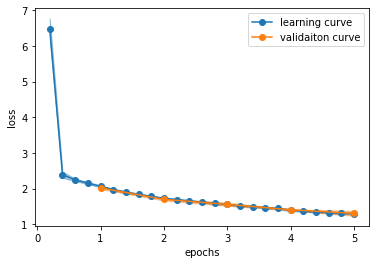

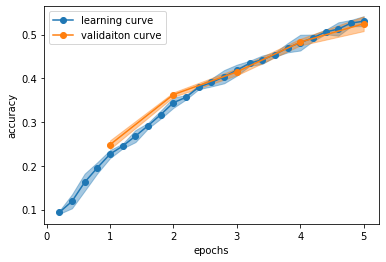

In [ ]:
scoresss = cross_validation(AlexNet, {},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.001, "momentum":0.9},
                 batch_size=32, epoch_size=5, repsize=3,
                 random_state=42, modelname="AlexNet_CEL", device="cuda:0")
np.save("AlexNet.npy", np.array(scoresss))
plot_validation_curve(np.array(scoresss))

#### AlexNet, CEL, Adam, lr=0.001, batch=128

In [ ]:
scoresss = cross_validation(AlexNet, {},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.001, "momentum":0.9},
                 batch_size=128, verbose_interbal=300, epoch_size=10, repsize=1,
                 random_state=42, modelname="AlexNet_CEL_Adam", device="cuda:0")
np.save("AlexNet_Adam.npy", np.array(scoresss))
plot_validation_curve(np.array(scoresss))

UnboundLocalError: ignored

### 正則化，Augumentation追加

#### 実装

In [ ]:
class AlexNet_Ver(nn.Module):
  def __init__(self, num_classes=1000, dropout_ratio=0.1):
    super(self.__class__, self).__init__()
    self.num_classes = num_classes

    self.relu = F.relu
    
    self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.dropout1 = nn.Dropout2d(p=dropout_ratio)
    self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
    self.batchnorm1 = nn.BatchNorm2d(256)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
    self.dropout2 = nn.Dropout2d(p=dropout_ratio)
    self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
    self.batchnorm2 = nn.BatchNorm2d(256)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(256 * 4 * 4, 4096)
    self.dropout3 = nn.Dropout2d(p=dropout_ratio)
    self.fc2 = nn.Linear(4096, 4096)
    self.batchnorm3 = nn.BatchNorm1d(4096)
    self.fc3 = nn.Linear(4096, num_classes)
 
  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool1(x)
    x = self.dropout1(x)
    x = self.conv2(x)
    x = self.batchnorm1(x)
    x = self.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.relu(x)
    x = self.dropout2(x)
    x = self.conv4(x)
    x = self.relu(x)
    x = self.conv5(x)
    x = self.batchnorm2(x)
    x = self.relu(x)
    x = self.pool3(x)
    x = x.view(-1, self.num_flat_features(x))
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout3(x)
    x = self.fc2(x)
    x = self.batchnorm3(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x
 
  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


In [ ]:
model = AlexNet_Ver(10, 0.01)
model = model.to("cuda:0")
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,688
         MaxPool2d-2           [-1, 96, 16, 16]               0
         Dropout2d-3           [-1, 96, 16, 16]               0
            Conv2d-4          [-1, 256, 16, 16]         614,656
       BatchNorm2d-5          [-1, 256, 16, 16]             512
         MaxPool2d-6            [-1, 256, 8, 8]               0
            Conv2d-7            [-1, 384, 8, 8]         885,120
         Dropout2d-8            [-1, 384, 8, 8]               0
            Conv2d-9            [-1, 384, 8, 8]       1,327,488
           Conv2d-10            [-1, 256, 8, 8]         884,992
      BatchNorm2d-11            [-1, 256, 8, 8]             512
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Linear-13                 [-1, 4096]      16,781,312
        Dropout2d-14                 [-

In [ ]:
def cross_validation_aug(modelclass, modelparams,
                          critclass, critparams,
                          optimclass, optimparams, 
                          batch_size=4, epoch_size=5, 
                          repsize=3, validsize=0.1, modelname="", 
                          random_state=42, repstart=0,
                          device="cuda:0", verbose=True, verbose_interval="auto"):
  transform_aug = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),  # 左右反転
     transforms.RandomAffine(degrees=0.2, scale=(0.8,1.2)),  # 拡大縮小回転
     transforms.ToTensor(),  # torch.Tensor へ変換
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 正規化する
     ])
  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_aug)
  #trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
  #                                          shuffle=True, num_workers=2)
  
  if verbose_interval=="auto":
    verbose_interval = 40000 // batch_size // 5
  # Hold-out を r 回
  scoresss = []
  for r in range(repstart, repsize):
    print(f"loop {r+1}")
    learn_dataset, valid_dataset = torch.utils.data.random_split(
        trainset,
        [len(trainset) - int(len(trainset)*validsize), int(len(trainset)*validsize)])
    learn_dataloader = DataLoader(learn_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=2)
    valid_dataloader = DataLoader(valid_dataset,
                                  shuffle=False, num_workers=2)

    model = modelclass(**modelparams)
    model = model.to(device)
    criterion = critclass(**critparams)
    optimizer = optimclass(model.parameters(), **optimparams)

    scoress = []
    for epoch in range(epoch_size):
      # 学習
      model.train()
      print(f"  epoch {epoch+1} | ", end="")

      learn_loss = 0.0
      learn_correct = 0
      learn_total = 0
      scores = []
      for i, data in enumerate(learn_dataloader):
        #print(i, len(data))
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        learn_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        learn_correct += (predicted == labels).sum().item()
        learn_total += labels.size(0)

        if i % verbose_interval == verbose_interval-1:
          print('\n    [%d, %5d] loss: %.4f, acc: %.4f' % # [epoch_count, sample_count]
                (epoch + 1, batch_size * (i + 1), learn_loss / verbose_interval, learn_correct / learn_total),
                end="")
          scores += [[learn_loss/verbose_interval, learn_correct/learn_total]]
          learn_loss = 0.0
          learn_correct = 0
          learn_total = 0
      
      # バリデーション
      model.eval()
      with torch.no_grad():
        valid_loss = 0.0
        valid_correct = 0
        valid_total = 0
        for data in valid_dataloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          valid_correct += (predicted == labels).sum().item()
          valid_total += labels.size(0)
          valid_loss += criterion(outputs, labels).item()
      scores += [[valid_loss/valid_total, valid_correct/valid_total]]
      print(f' | validation loss: {valid_loss / valid_total:.4f}, acc: {valid_correct / valid_total:.4f}')
      scoress += [scores]
    scoresss += [scoress]
    torch.save(model.state_dict(), f"./{modelname}_{r}.pth")
  # [[learn_loss, learn_acc] * minibatch , [valid_loss, valid_acc]] * epoch * loop
  return scoresss


#### AlexNet + Aug + Norm, dropout=0.1, SGD, lr=0.001, momentum=0.9, weight_decay=1e-3, batch=128

In [ ]:
scoresss = cross_validation_aug(AlexNet_Ver, {"num_classes":1000, "dropout_ratio":0.1},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.001, "momentum":0.9, "weight_decay":1e-3},
                 batch_size=128, epoch_size=15, repsize=1,
                 random_state=42, modelname="AlexNet_Aug_Norm", device="cuda:0")

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 2.6957, acc: 0.2903
    [1, 15872] loss: 1.6571, acc: 0.3971
    [1, 23808] loss: 1.5011, acc: 0.4624
    [1, 31744] loss: 1.4627, acc: 0.4733
    [1, 39680] loss: 1.4019, acc: 0.4937 | validation loss: 1.3011, acc: 0.5402
  epoch 2 | 
    [2,  7936] loss: 1.3150, acc: 0.5267
    [2, 15872] loss: 1.2726, acc: 0.5479
    [2, 23808] loss: 1.2201, acc: 0.5566
    [2, 31744] loss: 1.2311, acc: 0.5572
    [2, 39680] loss: 1.1916, acc: 0.5799 | validation loss: 1.1132, acc: 0.6134
  epoch 3 | 
    [3,  7936] loss: 1.1152, acc: 0.6047
    [3, 15872] loss: 1.0890, acc: 0.6106
    [3, 23808] loss: 1.0600, acc: 0.6227
    [3, 31744] loss: 1.0448, acc: 0.6316
    [3, 39680] loss: 1.0437, acc: 0.6365 | validation loss: 0.9540, acc: 0.6616
  epoch 4 | 
    [4,  7936] loss: 0.9661, acc: 0.6605
    [4, 15872] loss: 0.9886, acc: 0.6499
    [4, 23808] loss: 0.9764, acc: 0.6561
    [4, 31744] loss: 0.9554, acc: 0.6638
    [4,

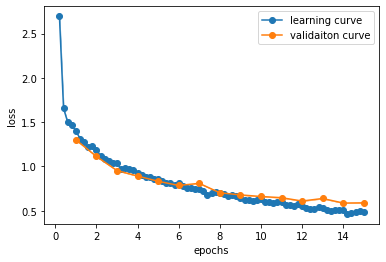

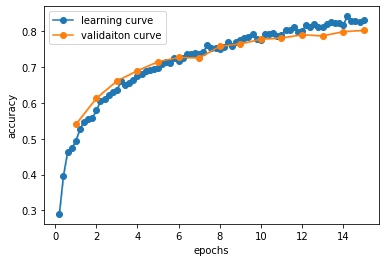

In [ ]:
np.save("AlexNet_Aug_Norm.npy", np.array(scoresss))
plot_validation_curve(np.array(scoresss))

In [ ]:
model = AlexNet_Ver(1000, 0.1)
model.load_state_dict(torch.load("AlexNet_Aug_Norm_0.pth"))
test(model)

Accuracy of the network on the 10000 test images: 80 %


#### ☆ AlexNet + Aug + Norm, dropout=0.01, SGD, lr=0.01, momentum=0.9, weight_decay=1e-3, batch=128

In [ ]:
scoresss = cross_validation_aug(AlexNet_Ver, {"num_classes":10, "dropout_ratio":0.01},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.01, "momentum":0.9, "weight_decay":1e-3},
                 batch_size=128, epoch_size=15, repsize=1,
                 random_state=42, modelname="AlexNet_Aug_Norm-2", device="cuda:0")

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 2.0597, acc: 0.3117
    [1, 15872] loss: 1.7860, acc: 0.4047
    [1, 23808] loss: 1.6095, acc: 0.4538
    [1, 31744] loss: 1.5257, acc: 0.4855
    [1, 39680] loss: 1.4789, acc: 0.5103 | validation loss: 1.3694, acc: 0.5180
  epoch 2 | 
    [2,  7936] loss: 1.3443, acc: 0.5525
    [2, 15872] loss: 1.2482, acc: 0.5756
    [2, 23808] loss: 1.1847, acc: 0.5987
    [2, 31744] loss: 1.1591, acc: 0.6024
    [2, 39680] loss: 1.1424, acc: 0.6050 | validation loss: 1.4063, acc: 0.5402
  epoch 3 | 
    [3,  7936] loss: 1.0431, acc: 0.6438
    [3, 15872] loss: 1.0220, acc: 0.6469
    [3, 23808] loss: 1.0283, acc: 0.6484
    [3, 31744] loss: 0.9918, acc: 0.6594
    [3, 39680] loss: 0.9538, acc: 0.6705 | validation loss: 1.0023, acc: 0.6594
  epoch 4 | 
    [4,  7936] loss: 0.8574, acc: 0.7021
    [4, 15872] loss: 0.8679, acc: 0.6998
    [4, 23808] loss: 0.8340, acc: 0.7126
    [4, 31744] loss: 0.8665, acc: 0.7022
    [4,

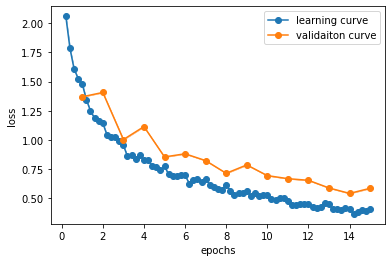

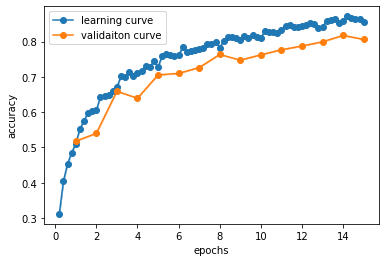

Accuracy of the network on the 10000 test images: 81 %


In [ ]:
np.save("AlexNet_Aug_Norm-2.npy", np.array(scoresss))
plot_validation_curve(np.array(scoresss))

model = AlexNet_Ver(10, 0.01)
model.load_state_dict(torch.load("AlexNet_Aug_Norm-2_0.pth"))
test(model)

In [ ]:
model = AlexNet_Ver(10, 0.01)
model.to("cpu")
model.load_state_dict(torch.load("AlexNet_Aug_Norm-2_0.pth", map_location=torch.device('cpu')))
test(model, device="cpu")

Accuracy of the network on the 10000 test images: 81.69 %


#### AlexNet + Aug + Norm, dropout=0.01, SGD, lr=0.01, momentum=0.9, weight_decay=1e-4, batch=4, 64, 400

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  8000] loss: 6.8565, acc: 0.1163
    [1, 16000] loss: 2.3350, acc: 0.1426
    [1, 24000] loss: 2.2464, acc: 0.1593
    [1, 32000] loss: 2.1896, acc: 0.1826
    [1, 40000] loss: 2.1669, acc: 0.1832 | validation loss: 2.3992, acc: 0.2292
  epoch 2 | 
    [2,  8000] loss: 2.1320, acc: 0.2000
    [2, 16000] loss: 2.1147, acc: 0.2101
    [2, 24000] loss: 2.0836, acc: 0.2199
    [2, 32000] loss: 2.0657, acc: 0.2285
    [2, 40000] loss: 2.0136, acc: 0.2437 | validation loss: 1.8866, acc: 0.3144
  epoch 3 | 
    [3,  8000] loss: 1.9565, acc: 0.2756
    [3, 16000] loss: 1.8970, acc: 0.2984
    [3, 24000] loss: 1.8637, acc: 0.3215
    [3, 32000] loss: 1.8341, acc: 0.3370
    [3, 40000] loss: 1.7792, acc: 0.3555 | validation loss: 1.6017, acc: 0.4326
  epoch 4 | 
    [4,  8000] loss: 1.7531, acc: 0.3680
    [4, 16000] loss: 1.6995, acc: 0.3851
    [4, 24000] loss: 1.7009, acc: 0.3914
    [4, 32000] loss: 1.6742, acc: 0.3990
    [4,

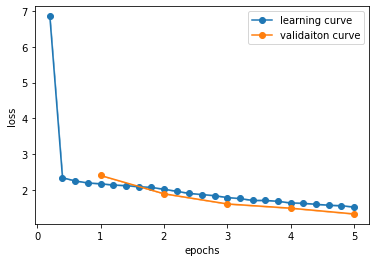

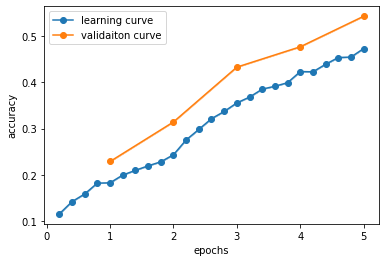

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  8000] loss: 2.6862, acc: 0.2652
    [1, 16000] loss: 2.7145, acc: 0.2901
    [1, 24000] loss: 2.2113, acc: 0.3314
    [1, 32000] loss: 2.3215, acc: 0.3752
    [1, 40000] loss: 2.1569, acc: 0.3523 | validation loss: 1.8152, acc: 0.3904
  epoch 2 | 
    [2,  8000] loss: 1.7328, acc: 0.4366
    [2, 16000] loss: 1.5835, acc: 0.4636
    [2, 24000] loss: 1.4930, acc: 0.4989
    [2, 32000] loss: 1.3473, acc: 0.5309
    [2, 40000] loss: 1.3165, acc: 0.5376 | validation loss: 1.3037, acc: 0.5576
  epoch 3 | 
    [3,  8000] loss: 1.2417, acc: 0.5677
    [3, 16000] loss: 1.1936, acc: 0.5841
    [3, 24000] loss: 1.1416, acc: 0.5931
    [3, 32000] loss: 1.1386, acc: 0.5939
    [3, 40000] loss: 1.0664, acc: 0.6185 | validation loss: 1.0931, acc: 0.6158
  epoch 4 | 
    [4,  8000] loss: 1.1642, acc: 0.6018
    [4, 16000] loss: 1.0267, acc: 0.6359
    [4, 24000] loss: 0.9960, acc: 0.6458
    [4, 32000] loss: 0.9812, acc: 0.6581
    [4,

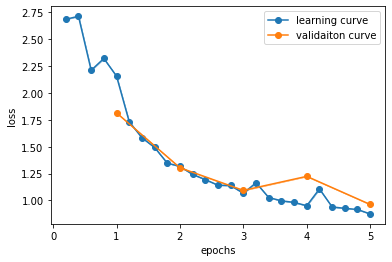

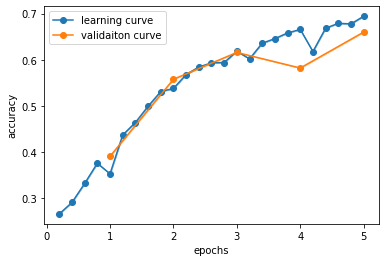

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  8000] loss: 1.8128, acc: 0.3386
    [1, 16000] loss: 1.5786, acc: 0.4351
    [1, 24000] loss: 1.4469, acc: 0.4824
    [1, 32000] loss: 1.3584, acc: 0.5165
    [1, 40000] loss: 1.2954, acc: 0.5299 | validation loss: 1.5840, acc: 0.4662
  epoch 2 | 
    [2,  8000] loss: 1.1257, acc: 0.6005
    [2, 16000] loss: 1.1010, acc: 0.6084
    [2, 24000] loss: 1.0368, acc: 0.6302
    [2, 32000] loss: 1.0083, acc: 0.6425
    [2, 40000] loss: 0.9966, acc: 0.6475 | validation loss: 1.1698, acc: 0.5924
  epoch 3 | 
    [3,  8000] loss: 0.8789, acc: 0.6939
    [3, 16000] loss: 0.8863, acc: 0.6887
    [3, 24000] loss: 0.8418, acc: 0.7085
    [3, 32000] loss: 0.8692, acc: 0.7019
    [3, 40000] loss: 0.8456, acc: 0.6990 | validation loss: 0.9318, acc: 0.6790
  epoch 4 | 
    [4,  8000] loss: 0.7912, acc: 0.7204
    [4, 16000] loss: 0.7500, acc: 0.7350
    [4, 24000] loss: 0.7549, acc: 0.7418
    [4, 32000] loss: 0.7275, acc: 0.7518
    [4,

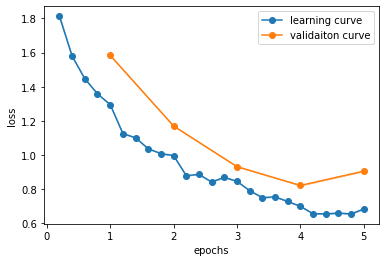

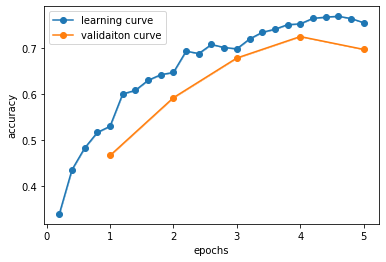

In [ ]:
modelname="AlexNet_Aug_Norm-3_batch"
scores4 = []
for batch_size in 4,64,400:
  scores3 = cross_validation_aug(AlexNet_Ver, {"num_classes":10, "dropout_ratio":0.001},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.01, "momentum":0.9, "weight_decay":1e-4},
                 batch_size=batch_size, epoch_size=5, repsize=1,
                 random_state=42, modelname=f"{modelname}_{batch_size}", device="cuda:0")
  
  np.save(f"{modelname}_{batch_size}.npy", np.array(scores3))
  plot_validation_curve(np.array(scores3))

  scores4 += [scores3]
scores4 = np.array(scores3)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
scores4 = [np.load(f"AlexNet_Aug_Norm-3_batch_4.npy"), np.load(f"AlexNet_Aug_Norm-3_batch_64.npy"), np.load(f"AlexNet_Aug_Norm-2.npy")[:, :5, :, :], np.load(f"AlexNet_Aug_Norm-3_batch_400.npy")]

In [ ]:
scores4 = np.array(scores4)
scores4.shape

(4, 1, 5, 6, 2)

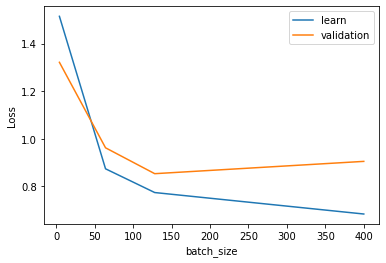

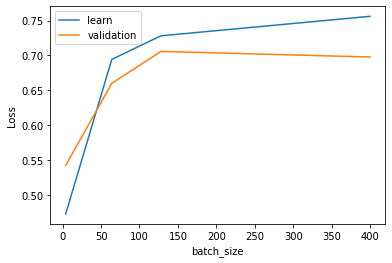

In [ ]:
plt.plot([4,64,128,400], scores4[:,0,-1,-2,0], label="learn")
plt.plot([4,64,128,400], scores4[:,0,-1,-1,0], label="validation")
plt.xlabel("batch_size")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot([4,64,128,400], scores4[:,0,-1,-2,1], label="learn")
plt.plot([4,64,128,400], scores4[:,0,-1,-1,1], label="validation")
plt.xlabel("batch_size")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### AlexNet + Aug + Norm, dropout=0.001, 0.01, 0.1, SGD, lr=0.01, momentum=0.9, weight_decay=1e-4, batch=128

In [ ]:
modelname="AlexNet_Aug_Norm-4_DO"
scores4 = []
for dropout in 0.001, 0.01, 0.1:
  scores3 = cross_validation_aug(AlexNet_Ver, {"num_classes":10, "dropout_ratio":dropout},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.01, "momentum":0.9, "weight_decay":1e-4},
                 batch_size=128, epoch_size=5, repsize=1,
                 random_state=42, modelname=f"{modelname}_{dropout}", device="cuda:0")
  
  np.save(f"{modelname}_{dropout}.npy", np.array(scores3))
  plot_validation_curve(np.array(scores3))
  scores4 += [scores3]
scores4 = np.array(scores4)

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 2.0782, acc: 0.3138
    [1, 15872] loss: 1.8119, acc: 0.4073
    [1, 23808] loss: 1.8575, acc: 0.4340
    [1, 31744] loss: 1.6463, acc: 0.4739
    [1, 39680] loss: 1.6474, acc: 0.5025 | validation loss: 1.7383, acc: 0.4290
  epoch 2 | 
    [2,  7936] loss: 1.4112, acc: 0.5242
    [2, 15872] loss: 1.3082, acc: 0.5586
    [2, 23808] loss: 1.2066, acc: 0.5987
    [2, 31744] loss: 1.1724, acc: 0.6153
    [2, 39680] loss: 1.2204, acc: 0.5903 | validation loss: 1.0960, acc: 0.6300
  epoch 3 | 
    [3,  7936] loss: 1.0073, acc: 0.6512
    [3, 15872] loss: 1.0074, acc: 0.6573
    [3, 23808] loss: 0.9857, acc: 0.6618
    [3, 31744] loss: 0.9631, acc: 0.6755
    [3, 39680] loss: 0.9131, acc: 0.6748 | validation loss: 0.9396, acc: 0.6816
  epoch 4 | 
    [4,  7936] loss: 0.8406, acc: 0.7045
    [4, 15872] loss: 0.8564, acc: 0.7020
    [4, 23808] loss: 0.8366, acc: 0.7074
    [4, 31744] loss: 0.8250, acc: 0.7171
    [4,

NameError: ignored

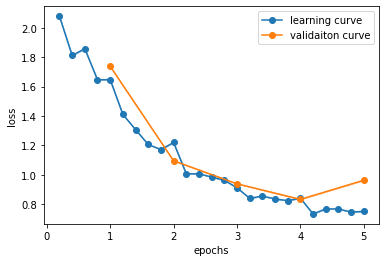

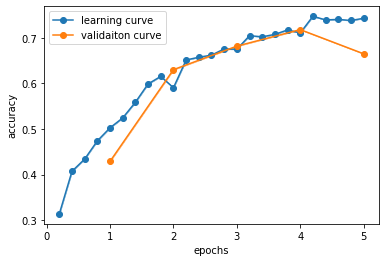

In [ ]:
plot_learning_curve(np.array(scores3))

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 1.9932, acc: 0.3191
    [1, 15872] loss: 2.0029, acc: 0.3747
    [1, 23808] loss: 1.7695, acc: 0.4249
    [1, 31744] loss: 1.6811, acc: 0.4641
    [1, 39680] loss: 1.4743, acc: 0.5042 | validation loss: 1.4921, acc: 0.4832
  epoch 2 | 
    [2,  7936] loss: 1.4378, acc: 0.5450
    [2, 15872] loss: 1.3191, acc: 0.5604
    [2, 23808] loss: 1.2134, acc: 0.5846
    [2, 31744] loss: 1.1690, acc: 0.6125
    [2, 39680] loss: 1.1022, acc: 0.6200 | validation loss: 1.1558, acc: 0.6068
  epoch 3 | 
    [3,  7936] loss: 1.0560, acc: 0.6410
    [3, 15872] loss: 0.9855, acc: 0.6525
    [3, 23808] loss: 0.9608, acc: 0.6658
    [3, 31744] loss: 0.9403, acc: 0.6723
    [3, 39680] loss: 0.9081, acc: 0.6879 | validation loss: 1.0119, acc: 0.6566
  epoch 4 | 
    [4,  7936] loss: 0.8645, acc: 0.7005
    [4, 15872] loss: 0.8265, acc: 0.7094
    [4, 23808] loss: 0.8368, acc: 0.7140
    [4, 31744] loss: 0.8264, acc: 0.7141
    [4,

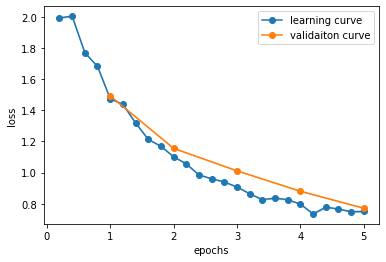

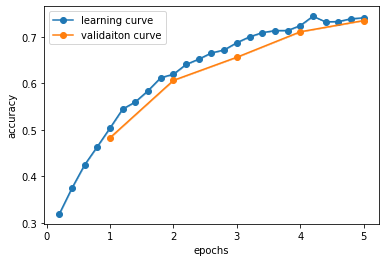

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 2.0581, acc: 0.2807
    [1, 15872] loss: 2.0446, acc: 0.3489
    [1, 23808] loss: 1.9031, acc: 0.3861
    [1, 31744] loss: 1.9328, acc: 0.4059
    [1, 39680] loss: 1.7378, acc: 0.4287 | validation loss: 1.8274, acc: 0.4450
  epoch 2 | 
    [2,  7936] loss: 1.4943, acc: 0.5060
    [2, 15872] loss: 1.4832, acc: 0.5098
    [2, 23808] loss: 1.3940, acc: 0.5232
    [2, 31744] loss: 1.3558, acc: 0.5399
    [2, 39680] loss: 1.2081, acc: 0.5882 | validation loss: 1.2138, acc: 0.5804
  epoch 3 | 
    [3,  7936] loss: 1.1115, acc: 0.6184
    [3, 15872] loss: 1.1122, acc: 0.6173
    [3, 23808] loss: 1.0860, acc: 0.6304
    [3, 31744] loss: 1.0526, acc: 0.6499
    [3, 39680] loss: 1.0249, acc: 0.6406 | validation loss: 1.0724, acc: 0.6510
  epoch 4 | 
    [4,  7936] loss: 0.9878, acc: 0.6569
    [4, 15872] loss: 0.9384, acc: 0.6759
    [4, 23808] loss: 0.9135, acc: 0.6818
    [4, 31744] loss: 0.9364, acc: 0.6818
    [4,

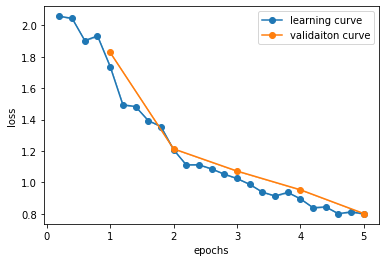

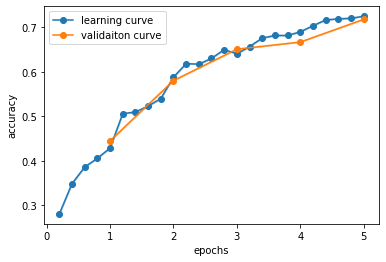

In [ ]:
#modelname="AlexNet_Aug_Norm-4_DO"
#scores4 = []
for dropout in 0.01, 0.1:
  scores3 = cross_validation_aug(AlexNet_Ver, {"num_classes":10, "dropout_ratio":dropout},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.01, "momentum":0.9, "weight_decay":1e-4},
                 batch_size=128, epoch_size=5, repsize=1,
                 random_state=42, modelname=f"{modelname}_{dropout}", device="cuda:0")
  
  np.save(f"{modelname}_{dropout}.npy", np.array(scores3))
  plot_learning_curve(np.array(scores3))
  scores4 += [scores3]
scores4 = np.array(scores4)

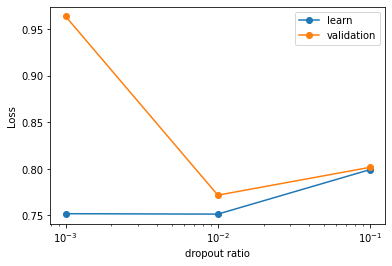

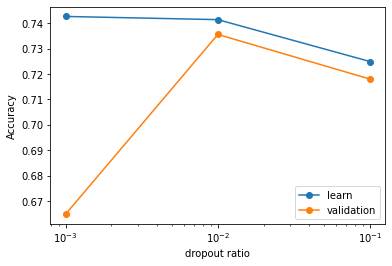

In [ ]:
plt.plot([0.001, 0.01, 0.1], scores4[:,0,-1,-2,0], marker="o", label="learn")
plt.plot([0.001, 0.01, 0.1], scores4[:,0,-1,-1,0], marker="o", label="validation")
plt.xscale("log")
plt.xlabel("dropout ratio")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot([0.001, 0.01, 0.1], scores4[:,0,-1,-2,1], marker="o", label="learn")
plt.plot([0.001, 0.01, 0.1], scores4[:,0,-1,-1,1], marker="o", label="validation")
plt.xscale("log")
plt.xlabel("dropout ratio")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### AlexNet + Aug + Norm, dropout=0.01, SGD, lr=0.01, momentum=0.9, weight_decay=1e-2, ..., 1e-5, batch=128

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 2.0439, acc: 0.3004
    [1, 15872] loss: 1.8159, acc: 0.3959
    [1, 23808] loss: 1.7156, acc: 0.4417
    [1, 31744] loss: 1.5935, acc: 0.4778
    [1, 39680] loss: 1.4741, acc: 0.5021 | validation loss: 1.9078, acc: 0.4364
  epoch 2 | 
    [2,  7936] loss: 1.4556, acc: 0.5292
    [2, 15872] loss: 1.3262, acc: 0.5523
    [2, 23808] loss: 1.2381, acc: 0.5745
    [2, 31744] loss: 1.2393, acc: 0.5843
    [2, 39680] loss: 1.1153, acc: 0.6190 | validation loss: 1.3106, acc: 0.5828
  epoch 3 | 
    [3,  7936] loss: 1.1115, acc: 0.6261
    [3, 15872] loss: 1.0022, acc: 0.6565
    [3, 23808] loss: 0.9529, acc: 0.6709
    [3, 31744] loss: 0.9798, acc: 0.6666
    [3, 39680] loss: 1.0108, acc: 0.6530 | validation loss: 0.9477, acc: 0.6698
  epoch 4 | 
    [4,  7936] loss: 0.9460, acc: 0.6799
    [4, 15872] loss: 0.8903, acc: 0.6978
    [4, 23808] loss: 0.8916, acc: 0.6952
    [4, 31744] loss: 0.8416, acc: 0.7119
    [4,

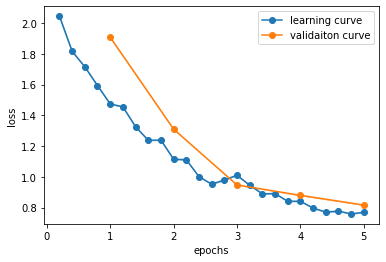

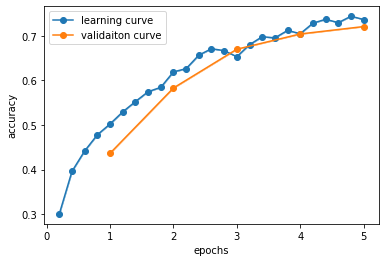

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 2.0700, acc: 0.2984
    [1, 15872] loss: 1.8820, acc: 0.3826
    [1, 23808] loss: 1.8823, acc: 0.4287
    [1, 31744] loss: 1.6437, acc: 0.4798
    [1, 39680] loss: 1.7560, acc: 0.4994 | validation loss: 1.4877, acc: 0.5098
  epoch 2 | 
    [2,  7936] loss: 1.3601, acc: 0.5619
    [2, 15872] loss: 1.3771, acc: 0.5456
    [2, 23808] loss: 1.3262, acc: 0.5689
    [2, 31744] loss: 1.2410, acc: 0.5835
    [2, 39680] loss: 1.1799, acc: 0.6120 | validation loss: 1.4556, acc: 0.5446
  epoch 3 | 
    [3,  7936] loss: 1.0702, acc: 0.6406
    [3, 15872] loss: 1.0882, acc: 0.6332
    [3, 23808] loss: 0.9962, acc: 0.6678
    [3, 31744] loss: 1.0648, acc: 0.6469
    [3, 39680] loss: 0.9851, acc: 0.6672 | validation loss: 0.9244, acc: 0.6810
  epoch 4 | 
    [4,  7936] loss: 0.9657, acc: 0.6758
    [4, 15872] loss: 0.9588, acc: 0.6721
    [4, 23808] loss: 0.9121, acc: 0.6898
    [4, 31744] loss: 0.8817, acc: 0.7054
    [4,

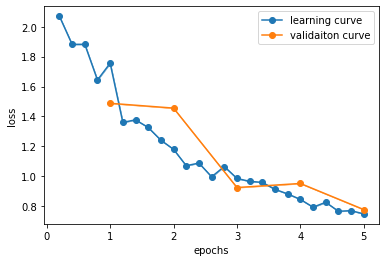

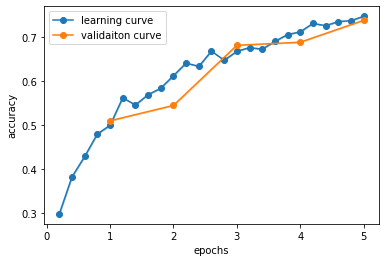

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 2.0817, acc: 0.2988
    [1, 15872] loss: 2.0335, acc: 0.3580
    [1, 23808] loss: 1.7659, acc: 0.4273
    [1, 31744] loss: 1.7507, acc: 0.4323
    [1, 39680] loss: 1.5593, acc: 0.4863 | validation loss: 2.1110, acc: 0.3808
  epoch 2 | 
    [2,  7936] loss: 1.4702, acc: 0.5126
    [2, 15872] loss: 1.3463, acc: 0.5507
    [2, 23808] loss: 1.3161, acc: 0.5679
    [2, 31744] loss: 1.2211, acc: 0.5910
    [2, 39680] loss: 1.2217, acc: 0.5939 | validation loss: 1.3551, acc: 0.5782
  epoch 3 | 
    [3,  7936] loss: 1.1312, acc: 0.6225
    [3, 15872] loss: 1.0746, acc: 0.6345
    [3, 23808] loss: 1.0998, acc: 0.6377
    [3, 31744] loss: 1.0365, acc: 0.6442
    [3, 39680] loss: 0.9844, acc: 0.6667 | validation loss: 1.4517, acc: 0.5724
  epoch 4 | 
    [4,  7936] loss: 0.9358, acc: 0.6806
    [4, 15872] loss: 0.8927, acc: 0.6966
    [4, 23808] loss: 0.8762, acc: 0.6959
    [4, 31744] loss: 0.8948, acc: 0.6920
    [4,

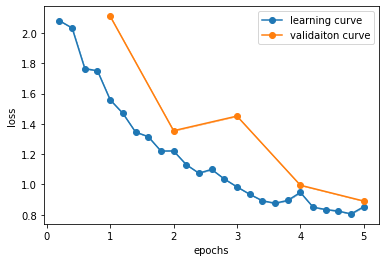

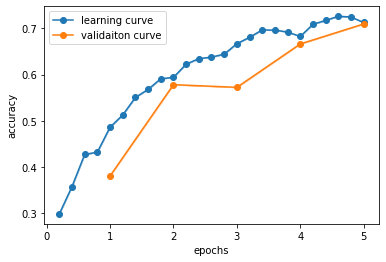

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 2.0749, acc: 0.2970
    [1, 15872] loss: 1.8057, acc: 0.3952
    [1, 23808] loss: 1.7379, acc: 0.4337
    [1, 31744] loss: 1.7153, acc: 0.4582
    [1, 39680] loss: 1.5300, acc: 0.4884 | validation loss: 1.3334, acc: 0.5406
  epoch 2 | 
    [2,  7936] loss: 1.3857, acc: 0.5423
    [2, 15872] loss: 1.2991, acc: 0.5788
    [2, 23808] loss: 1.3465, acc: 0.5625
    [2, 31744] loss: 1.1451, acc: 0.6161
    [2, 39680] loss: 1.1626, acc: 0.6090 | validation loss: 1.1063, acc: 0.6246
  epoch 3 | 
    [3,  7936] loss: 1.0784, acc: 0.6355
    [3, 15872] loss: 1.0465, acc: 0.6401
    [3, 23808] loss: 1.0016, acc: 0.6593
    [3, 31744] loss: 1.0070, acc: 0.6600
    [3, 39680] loss: 0.9746, acc: 0.6731 | validation loss: 1.0220, acc: 0.6626
  epoch 4 | 
    [4,  7936] loss: 0.8854, acc: 0.6929
    [4, 15872] loss: 0.8944, acc: 0.6929
    [4, 23808] loss: 0.8645, acc: 0.7051
    [4, 31744] loss: 0.8629, acc: 0.7045
    [4,

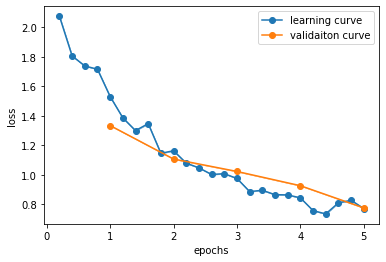

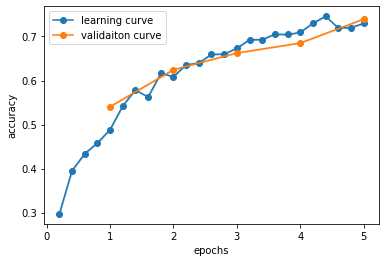

In [ ]:
modelname="AlexNet_Aug_Norm-5_WeightDecay"
scores4 = []
for wd in 1e-2,1e-3,1e-4,1e-5:
  scores3 = cross_validation_aug(AlexNet_Ver, {"num_classes":10, "dropout_ratio":0.01},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.01, "momentum":0.9, "weight_decay":1e-4},
                 batch_size=128, epoch_size=5, repsize=1,
                 random_state=42, modelname=f"{modelname}_{wd}", device="cuda:0")
  np.save(f"{modelname}_{wd}.npy", np.array(scores3))
  plot_learning_curve(np.array(scores3))
  scores4 += [scores3]
scores4 = np.array(scores4)

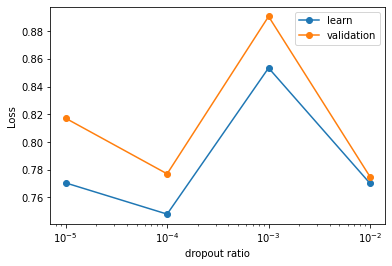

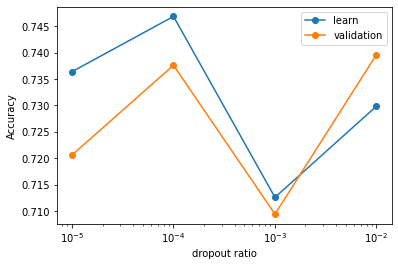

In [ ]:
plt.plot([10**(-5+i) for i in range(4)], scores4[:,0,-1,-2,0], marker="o", label="learn")
plt.plot([10**(-5+i) for i in range(4)], scores4[:,0,-1,-1,0], marker="o", label="validation")
plt.xscale("log")
plt.xlabel("dropout ratio")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot([10**(-5+i) for i in range(4)], scores4[:,0,-1,-2,1], marker="o", label="learn")
plt.plot([10**(-5+i) for i in range(4)], scores4[:,0,-1,-1,1], marker="o", label="validation")
plt.xscale("log")
plt.xlabel("dropout ratio")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
scores5 = scores4.tolist()

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 2.0134, acc: 0.3057
    [1, 15872] loss: 1.9945, acc: 0.3736
    [1, 23808] loss: 1.8860, acc: 0.4214
    [1, 31744] loss: 1.7284, acc: 0.4351
    [1, 39680] loss: 1.5982, acc: 0.4816 | validation loss: 1.5141, acc: 0.4688
  epoch 2 | 
    [2,  7936] loss: 1.3313, acc: 0.5558
    [2, 15872] loss: 1.2999, acc: 0.5651
    [2, 23808] loss: 1.1852, acc: 0.5960
    [2, 31744] loss: 1.2119, acc: 0.5885
    [2, 39680] loss: 1.1068, acc: 0.6265 | validation loss: 1.0688, acc: 0.6262
  epoch 3 | 
    [3,  7936] loss: 1.0528, acc: 0.6402
    [3, 15872] loss: 0.9916, acc: 0.6521
    [3, 23808] loss: 0.9757, acc: 0.6624
    [3, 31744] loss: 0.9566, acc: 0.6689
    [3, 39680] loss: 0.9514, acc: 0.6692 | validation loss: 0.9368, acc: 0.6828
  epoch 4 | 
    [4,  7936] loss: 0.8919, acc: 0.6881
    [4, 15872] loss: 0.8414, acc: 0.7029
    [4, 23808] loss: 0.8444, acc: 0.7039
    [4, 31744] loss: 0.8401, acc: 0.7099
    [4,

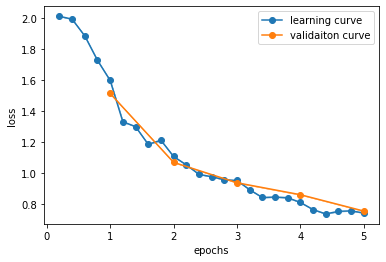

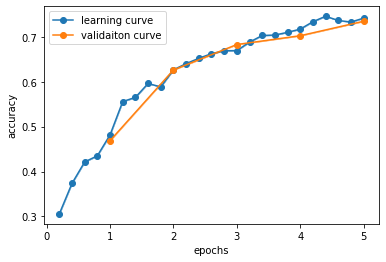

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 2.0709, acc: 0.2927
    [1, 15872] loss: 1.8924, acc: 0.3873
    [1, 23808] loss: 1.8290, acc: 0.4144
    [1, 31744] loss: 1.8264, acc: 0.4430
    [1, 39680] loss: 1.5645, acc: 0.4727 | validation loss: 1.4654, acc: 0.5008
  epoch 2 | 
    [2,  7936] loss: 1.4004, acc: 0.5345
    [2, 15872] loss: 1.3855, acc: 0.5444
    [2, 23808] loss: 1.2533, acc: 0.5769
    [2, 31744] loss: 1.1755, acc: 0.5891
    [2, 39680] loss: 1.0961, acc: 0.6211 | validation loss: 1.3721, acc: 0.5736
  epoch 3 | 
    [3,  7936] loss: 1.0963, acc: 0.6312
    [3, 15872] loss: 1.0366, acc: 0.6395
    [3, 23808] loss: 0.9914, acc: 0.6561
    [3, 31744] loss: 0.9922, acc: 0.6559
    [3, 39680] loss: 0.9436, acc: 0.6700 | validation loss: 1.1542, acc: 0.6086
  epoch 4 | 
    [4,  7936] loss: 0.8977, acc: 0.6862
    [4, 15872] loss: 0.8615, acc: 0.6982
    [4, 23808] loss: 0.8769, acc: 0.7031
    [4, 31744] loss: 0.8398, acc: 0.7040
    [4,

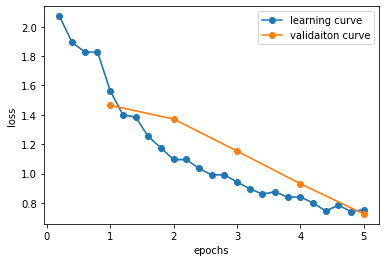

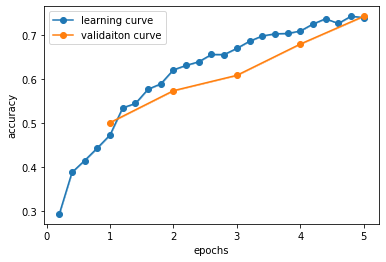

In [ ]:
modelname="AlexNet_Aug_Norm-5_WeightDecay"
scores4 = []
for wd in 4e-3,4e-4:
  scores3 = cross_validation_aug(AlexNet_Ver, {"num_classes":10, "dropout_ratio":0.01},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.01, "momentum":0.9, "weight_decay":1e-4},
                 batch_size=128, epoch_size=5, repsize=1,
                 random_state=42, modelname=f"{modelname}_{wd}", device="cuda:0")
  np.save(f"{modelname}_{wd}.npy", np.array(scores3))
  plot_learning_curve(np.array(scores3))
  scores4 += [scores3]
scores4 = np.array(scores4)

In [ ]:
#1e-5,-4,-3,-2
#scores5
#4e-3,4e-4
scores6=np.array([scores5[0],scores5[1],scores4.tolist()[1],scores5[2],scores4.tolist()[0],scores5[3]])

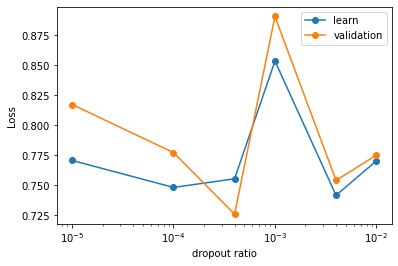

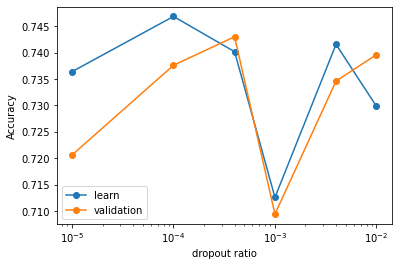

In [ ]:
plt.plot([1e-5,1e-4,4e-4,1e-3,4e-3,1e-2], scores6[:,0,-1,-2,0], marker="o", label="learn")
plt.plot([1e-5,1e-4,4e-4,1e-3,4e-3,1e-2], scores6[:,0,-1,-1,0], marker="o", label="validation")
plt.xscale("log")
plt.xlabel("dropout ratio")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot([1e-5,1e-4,4e-4,1e-3,4e-3,1e-2], scores6[:,0,-1,-2,1], marker="o", label="learn")
plt.plot([1e-5,1e-4,4e-4,1e-3,4e-3,1e-2], scores6[:,0,-1,-1,1], marker="o", label="validation")
plt.xscale("log")
plt.xlabel("dropout ratio")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### AlexNet + Aug + Norm, dropout=0.01, SGD, lr=0.1. 0.01, 0.001, momentum=0.9, weight_decay=4e-4, batch=128

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 14.0961, acc: 0.1103
    [1, 15872] loss: 4.1982, acc: 0.1148
    [1, 23808] loss: 2.6425, acc: 0.1273
    [1, 31744] loss: 2.4465, acc: 0.1562
    [1, 39680] loss: 2.2171, acc: 0.1947 | validation loss: 2.0923, acc: 0.2234
  epoch 2 | 
    [2,  7936] loss: 2.0622, acc: 0.2326
    [2, 15872] loss: 1.9518, acc: 0.2557
    [2, 23808] loss: 1.9315, acc: 0.2544
    [2, 31744] loss: 1.8933, acc: 0.2660
    [2, 39680] loss: 1.8683, acc: 0.2834 | validation loss: 1.8876, acc: 0.2566
  epoch 3 | 
    [3,  7936] loss: 1.8685, acc: 0.2839
    [3, 15872] loss: 1.8516, acc: 0.2925
    [3, 23808] loss: 1.7939, acc: 0.3163
    [3, 31744] loss: 1.7943, acc: 0.3208
    [3, 39680] loss: 1.7353, acc: 0.3358 | validation loss: 1.7358, acc: 0.3486
  epoch 4 | 
    [4,  7936] loss: 1.6805, acc: 0.3652
    [4, 15872] loss: 1.6519, acc: 0.3871
    [4, 23808] loss: 1.6289, acc: 0.3974
    [4, 31744] loss: 1.5954, acc: 0.4065
    [4

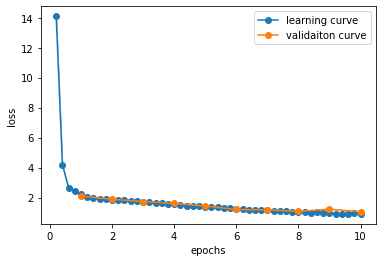

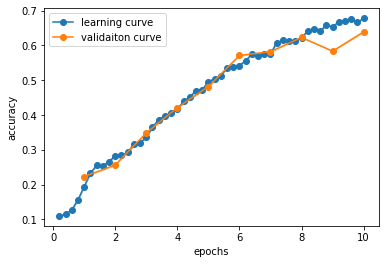

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 2.0599, acc: 0.3170
    [1, 15872] loss: 1.8457, acc: 0.4018
    [1, 23808] loss: 1.7534, acc: 0.4437
    [1, 31744] loss: 1.6226, acc: 0.4790
    [1, 39680] loss: 1.5953, acc: 0.5147 | validation loss: 1.2826, acc: 0.5592
  epoch 2 | 
    [2,  7936] loss: 1.2822, acc: 0.5780
    [2, 15872] loss: 1.2217, acc: 0.5867
    [2, 23808] loss: 1.1474, acc: 0.6134
    [2, 31744] loss: 1.1385, acc: 0.6120
    [2, 39680] loss: 1.0557, acc: 0.6331 | validation loss: 1.0281, acc: 0.6522
  epoch 3 | 
    [3,  7936] loss: 0.9632, acc: 0.6603
    [3, 15872] loss: 0.9443, acc: 0.6686
    [3, 23808] loss: 0.9070, acc: 0.6883
    [3, 31744] loss: 0.9277, acc: 0.6796
    [3, 39680] loss: 0.8670, acc: 0.6942 | validation loss: 1.0642, acc: 0.6378
  epoch 4 | 
    [4,  7936] loss: 0.8482, acc: 0.7050
    [4, 15872] loss: 0.8138, acc: 0.7121
    [4, 23808] loss: 0.8161, acc: 0.7114
    [4, 31744] loss: 0.8039, acc: 0.7223
    [4,

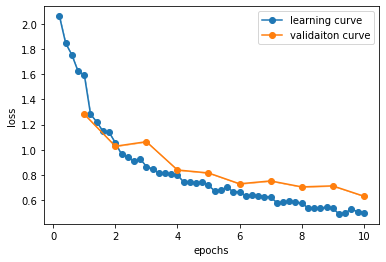

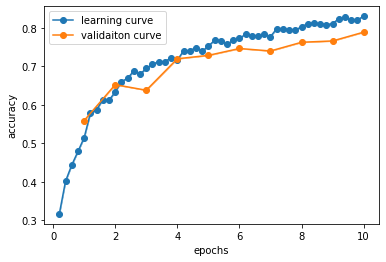

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 1.7656, acc: 0.3526
    [1, 15872] loss: 1.5115, acc: 0.4543
    [1, 23808] loss: 1.3749, acc: 0.4967
    [1, 31744] loss: 1.3043, acc: 0.5353
    [1, 39680] loss: 1.2595, acc: 0.5457 | validation loss: 1.1751, acc: 0.5734
  epoch 2 | 
    [2,  7936] loss: 1.1436, acc: 0.5931
    [2, 15872] loss: 1.1040, acc: 0.6130
    [2, 23808] loss: 1.0616, acc: 0.6305
    [2, 31744] loss: 1.0333, acc: 0.6327
    [2, 39680] loss: 1.0291, acc: 0.6386 | validation loss: 0.9662, acc: 0.6552
  epoch 3 | 
    [3,  7936] loss: 0.9553, acc: 0.6610
    [3, 15872] loss: 0.9127, acc: 0.6836
    [3, 23808] loss: 0.9024, acc: 0.6809
    [3, 31744] loss: 0.9140, acc: 0.6791
    [3, 39680] loss: 0.8735, acc: 0.6917 | validation loss: 0.8913, acc: 0.6838
  epoch 4 | 
    [4,  7936] loss: 0.7973, acc: 0.7233
    [4, 15872] loss: 0.8220, acc: 0.7116
    [4, 23808] loss: 0.8161, acc: 0.7080
    [4, 31744] loss: 0.7724, acc: 0.7303
    [4,

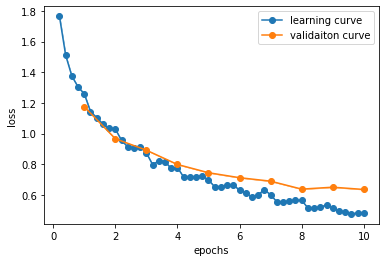

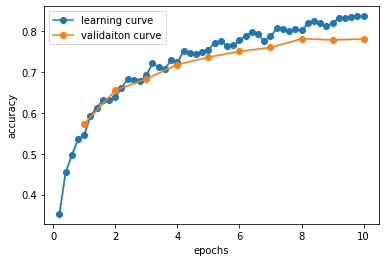

In [ ]:
modelname="AlexNet_Aug_Norm-6_lr"
scores4 = []
for lr in 0.1, 0.01, 0.001:
  scores3 = cross_validation_aug(AlexNet_Ver, {"num_classes":10, "dropout_ratio":0.01},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": lr, "momentum":0.9, "weight_decay":4e-4},
                 batch_size=128, epoch_size=10, repsize=1,
                 random_state=42, modelname=f"{modelname}_{lr}", device="cuda:0")
  np.save(f"{modelname}_{lr}.npy", np.array(scores3))
  plot_learning_curve(np.array(scores3))
  scores4 += [scores3]
scores4 = np.array(scores4)

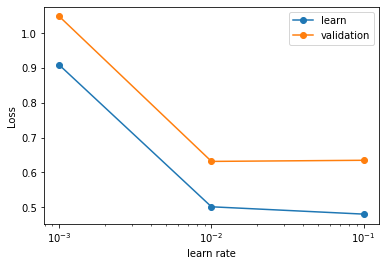

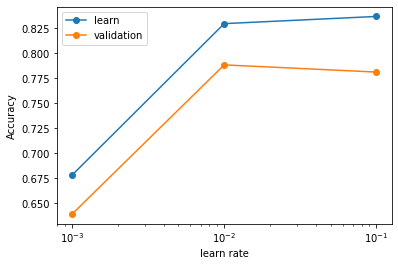

In [ ]:
plt.plot([0.001, 0.01, 0.1], scores4[:,0,-1,-2,0], marker="o", label="learn")
plt.plot([0.001, 0.01, 0.1], scores4[:,0,-1,-1,0], marker="o", label="validation")
plt.xscale("log")
plt.xlabel("learn rate")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot([0.001, 0.01, 0.1], scores4[:,0,-1,-2,1], marker="o", label="learn")
plt.plot([0.001, 0.01, 0.1], scores4[:,0,-1,-1,1], marker="o", label="validation")
plt.xscale("log")
plt.xlabel("learn rate")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### AlexNet + Aug + Norm, dropout=0.01, SGD, lr=0.01, momentum=0, 0.1, 0.5, 0.9, 0.95, weight_decay=4e-4, batch=128

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 1.7782, acc: 0.3580
    [1, 15872] loss: 1.4809, acc: 0.4657
    [1, 23808] loss: 1.4025, acc: 0.4902
    [1, 31744] loss: 1.3142, acc: 0.5273
    [1, 39680] loss: 1.2442, acc: 0.5515 | validation loss: 1.3726, acc: 0.5058
  epoch 2 | 
    [2,  7936] loss: 1.1442, acc: 0.5930
    [2, 15872] loss: 1.1292, acc: 0.5934
    [2, 23808] loss: 1.0723, acc: 0.6129
    [2, 31744] loss: 1.0659, acc: 0.6164
    [2, 39680] loss: 1.0264, acc: 0.6401 | validation loss: 1.1209, acc: 0.6024
  epoch 3 | 
    [3,  7936] loss: 0.9479, acc: 0.6663
    [3, 15872] loss: 0.9339, acc: 0.6667
    [3, 23808] loss: 0.9297, acc: 0.6724
    [3, 31744] loss: 0.9073, acc: 0.6748
    [3, 39680] loss: 0.8790, acc: 0.6917 | validation loss: 0.9567, acc: 0.6652
  epoch 4 | 
    [4,  7936] loss: 0.8183, acc: 0.7103
    [4, 15872] loss: 0.8024, acc: 0.7162
    [4, 23808] loss: 0.8114, acc: 0.7138
    [4, 31744] loss: 0.7917, acc: 0.7195
    [4,

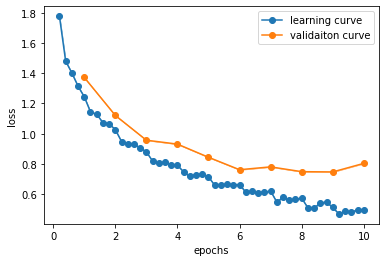

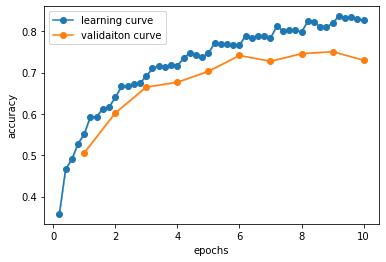

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 1.7360, acc: 0.3606
    [1, 15872] loss: 1.4666, acc: 0.4614
    [1, 23808] loss: 1.3571, acc: 0.5095
    [1, 31744] loss: 1.3024, acc: 0.5311
    [1, 39680] loss: 1.2284, acc: 0.5709 | validation loss: 1.3085, acc: 0.5448
  epoch 2 | 
    [2,  7936] loss: 1.0985, acc: 0.6161
    [2, 15872] loss: 1.0684, acc: 0.6232
    [2, 23808] loss: 1.0828, acc: 0.6148
    [2, 31744] loss: 1.0274, acc: 0.6339
    [2, 39680] loss: 0.9816, acc: 0.6550 | validation loss: 1.1427, acc: 0.6010
  epoch 3 | 
    [3,  7936] loss: 0.9241, acc: 0.6767
    [3, 15872] loss: 0.8867, acc: 0.6826
    [3, 23808] loss: 0.8929, acc: 0.6806
    [3, 31744] loss: 0.8676, acc: 0.7005
    [3, 39680] loss: 0.8671, acc: 0.6990 | validation loss: 0.9069, acc: 0.6900
  epoch 4 | 
    [4,  7936] loss: 0.7942, acc: 0.7194
    [4, 15872] loss: 0.7877, acc: 0.7264
    [4, 23808] loss: 0.7773, acc: 0.7273
    [4, 31744] loss: 0.7799, acc: 0.7290
    [4,

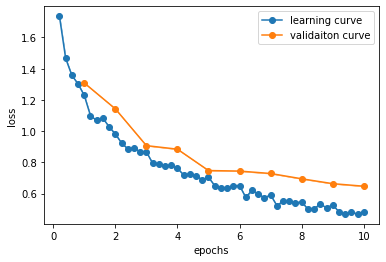

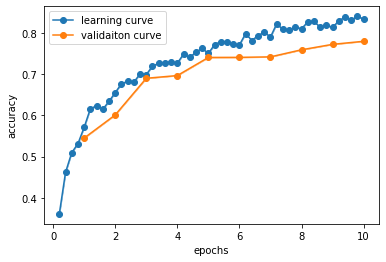

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 1.7420, acc: 0.3684
    [1, 15872] loss: 1.4834, acc: 0.4667
    [1, 23808] loss: 1.3692, acc: 0.5043
    [1, 31744] loss: 1.2961, acc: 0.5358
    [1, 39680] loss: 1.2003, acc: 0.5659 | validation loss: 1.3006, acc: 0.5484
  epoch 2 | 
    [2,  7936] loss: 1.0860, acc: 0.6162
    [2, 15872] loss: 1.0384, acc: 0.6261
    [2, 23808] loss: 1.0112, acc: 0.6450
    [2, 31744] loss: 0.9859, acc: 0.6429
    [2, 39680] loss: 0.9553, acc: 0.6661 | validation loss: 0.9220, acc: 0.6802
  epoch 3 | 
    [3,  7936] loss: 0.9049, acc: 0.6773
    [3, 15872] loss: 0.8415, acc: 0.7034
    [3, 23808] loss: 0.8303, acc: 0.7056
    [3, 31744] loss: 0.8315, acc: 0.7113
    [3, 39680] loss: 0.8168, acc: 0.7126 | validation loss: 0.9072, acc: 0.6900
  epoch 4 | 
    [4,  7936] loss: 0.7408, acc: 0.7370
    [4, 15872] loss: 0.7298, acc: 0.7429
    [4, 23808] loss: 0.7412, acc: 0.7446
    [4, 31744] loss: 0.7468, acc: 0.7351
    [4,

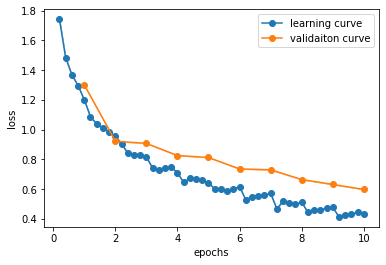

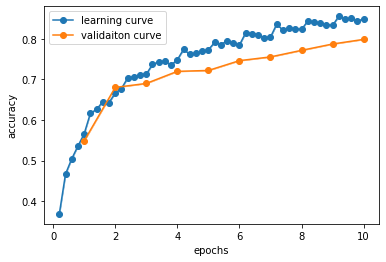

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 2.0763, acc: 0.3020
    [1, 15872] loss: 2.0041, acc: 0.3691
    [1, 23808] loss: 1.9301, acc: 0.4037
    [1, 31744] loss: 1.6193, acc: 0.4607
    [1, 39680] loss: 1.4588, acc: 0.5009 | validation loss: 1.4913, acc: 0.4738
  epoch 2 | 
    [2,  7936] loss: 1.3858, acc: 0.5226
    [2, 15872] loss: 1.3056, acc: 0.5563
    [2, 23808] loss: 1.2028, acc: 0.5921
    [2, 31744] loss: 1.1568, acc: 0.5980
    [2, 39680] loss: 1.1654, acc: 0.6038 | validation loss: 1.1721, acc: 0.5910
  epoch 3 | 
    [3,  7936] loss: 1.0279, acc: 0.6386
    [3, 15872] loss: 1.0084, acc: 0.6534
    [3, 23808] loss: 0.9674, acc: 0.6643
    [3, 31744] loss: 0.9667, acc: 0.6570
    [3, 39680] loss: 0.9066, acc: 0.6885 | validation loss: 1.1610, acc: 0.6126
  epoch 4 | 
    [4,  7936] loss: 0.8524, acc: 0.7012
    [4, 15872] loss: 0.8601, acc: 0.6980
    [4, 23808] loss: 0.8569, acc: 0.7034
    [4, 31744] loss: 0.8450, acc: 0.7050
    [4,

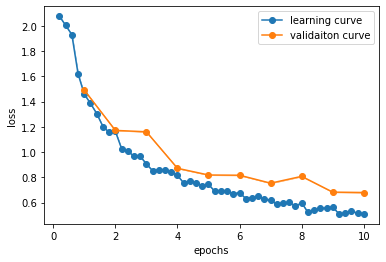

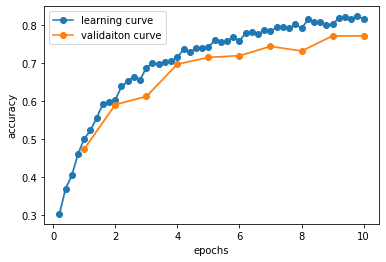

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 2.1341, acc: 0.2899
    [1, 15872] loss: 2.3637, acc: 0.3257
    [1, 23808] loss: 2.4573, acc: 0.3402
    [1, 31744] loss: 2.6137, acc: 0.3222
    [1, 39680] loss: 2.6806, acc: 0.3661 | validation loss: 2.9339, acc: 0.2664
  epoch 2 | 
    [2,  7936] loss: 3.7701, acc: 0.2674
    [2, 15872] loss: 2.3995, acc: 0.3275
    [2, 23808] loss: 2.4849, acc: 0.3842
    [2, 31744] loss: 1.8597, acc: 0.4361
    [2, 39680] loss: 1.8414, acc: 0.4556 | validation loss: 1.7867, acc: 0.4812
  epoch 3 | 
    [3,  7936] loss: 1.8304, acc: 0.4861
    [3, 15872] loss: 1.6665, acc: 0.4976
    [3, 23808] loss: 1.7430, acc: 0.4990
    [3, 31744] loss: 1.7376, acc: 0.4897
    [3, 39680] loss: 1.5742, acc: 0.5008 | validation loss: 1.7533, acc: 0.4924
  epoch 4 | 
    [4,  7936] loss: 1.5058, acc: 0.5287
    [4, 15872] loss: 1.4389, acc: 0.5391
    [4, 23808] loss: 1.2538, acc: 0.5678
    [4, 31744] loss: 1.3321, acc: 0.5663
    [4,

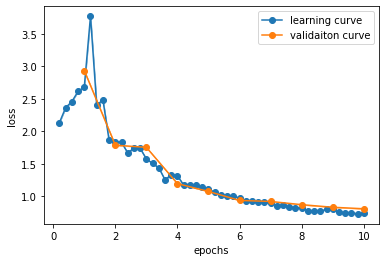

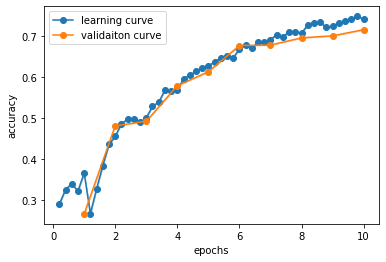

In [ ]:
modelname="AlexNet_Aug_Norm-7_momentum"
scores4 = []
for momentum in 0, 0.1, 0.5, 0.9, 0.95:
  scores3 = cross_validation_aug(AlexNet_Ver, {"num_classes":10, "dropout_ratio":0.01},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.01, "momentum":momentum, "weight_decay":4e-4},
                 batch_size=128, epoch_size=10, repsize=1,
                 random_state=42, modelname=f"{modelname}_{momentum}", device="cuda:0")
  np.save(f"{modelname}_{momentum}.npy", np.array(scores3))
  plot_learning_curve(np.array(scores3))
  scores4 += [scores3]
scores4 = np.array(scores4)

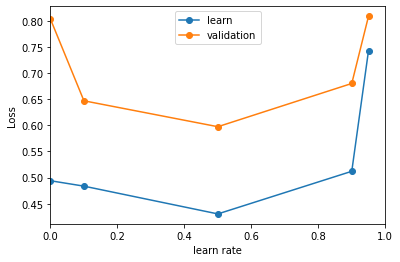

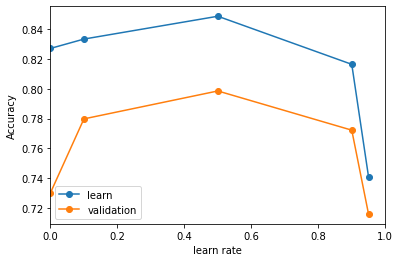

In [ ]:
plt.plot([0, 0.1, 0.5, 0.9, 0.95], scores4[:,0,-1,-2,0], marker="o", label="learn")
plt.plot([0, 0.1, 0.5, 0.9, 0.95], scores4[:,0,-1,-1,0], marker="o", label="validation")
#plt.xscale("log")
plt.xlim(0,1)
plt.xlabel("learn rate")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot([0, 0.1, 0.5, 0.9, 0.95], scores4[:,0,-1,-2,1], marker="o", label="learn")
plt.plot([0, 0.1, 0.5, 0.9, 0.95], scores4[:,0,-1,-1,1], marker="o", label="validation")
#plt.xscale("log")
plt.xlim(0,1)
plt.xlabel("learn rate")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 1.7423, acc: 0.3734
    [1, 15872] loss: 1.4543, acc: 0.4817
    [1, 23808] loss: 1.3478, acc: 0.5123
    [1, 31744] loss: 1.2603, acc: 0.5532
    [1, 39680] loss: 1.1697, acc: 0.5822 | validation loss: 1.2897, acc: 0.5456
  epoch 2 | 
    [2,  7936] loss: 1.0679, acc: 0.6230
    [2, 15872] loss: 1.0371, acc: 0.6313
    [2, 23808] loss: 1.0228, acc: 0.6332
    [2, 31744] loss: 0.9660, acc: 0.6571
    [2, 39680] loss: 0.9530, acc: 0.6666 | validation loss: 0.9495, acc: 0.6646
  epoch 3 | 
    [3,  7936] loss: 0.8516, acc: 0.7001
    [3, 15872] loss: 0.8151, acc: 0.7147
    [3, 23808] loss: 0.8608, acc: 0.7021
    [3, 31744] loss: 0.8569, acc: 0.7043
    [3, 39680] loss: 0.8179, acc: 0.7123 | validation loss: 0.8859, acc: 0.6910
  epoch 4 | 
    [4,  7936] loss: 0.7760, acc: 0.7269
    [4, 15872] loss: 0.7554, acc: 0.7345
    [4, 23808] loss: 0.7545, acc: 0.7355
    [4, 31744] loss: 0.7398, acc: 0.7455
    [4,

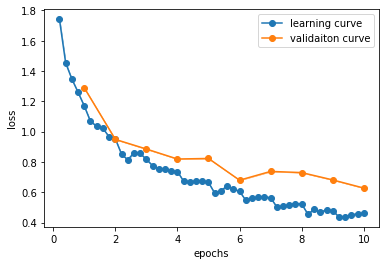

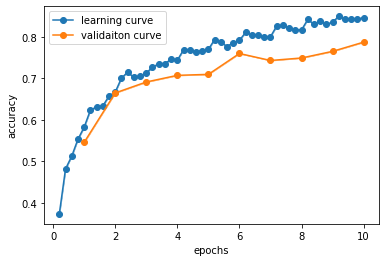

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 1.7908, acc: 0.3638
    [1, 15872] loss: 1.5339, acc: 0.4500
    [1, 23808] loss: 1.3683, acc: 0.5095
    [1, 31744] loss: 1.3053, acc: 0.5401
    [1, 39680] loss: 1.1910, acc: 0.5748 | validation loss: 1.2421, acc: 0.5674
  epoch 2 | 
    [2,  7936] loss: 1.0614, acc: 0.6215
    [2, 15872] loss: 0.9944, acc: 0.6479
    [2, 23808] loss: 0.9988, acc: 0.6473
    [2, 31744] loss: 0.9725, acc: 0.6581
    [2, 39680] loss: 0.9168, acc: 0.6813 | validation loss: 0.9880, acc: 0.6658
  epoch 3 | 
    [3,  7936] loss: 0.8389, acc: 0.7012
    [3, 15872] loss: 0.8260, acc: 0.7087
    [3, 23808] loss: 0.8152, acc: 0.7164
    [3, 31744] loss: 0.7869, acc: 0.7316
    [3, 39680] loss: 0.8165, acc: 0.7126 | validation loss: 0.9763, acc: 0.6616
  epoch 4 | 
    [4,  7936] loss: 0.6978, acc: 0.7538
    [4, 15872] loss: 0.7069, acc: 0.7487
    [4, 23808] loss: 0.7336, acc: 0.7491
    [4, 31744] loss: 0.7008, acc: 0.7559
    [4,

In [ ]:
modelname="AlexNet_Aug_Norm-7_momentum"
scores5 = []
for momentum in 0.3, 0.7:
  scores3 = cross_validation_aug(AlexNet_Ver, {"num_classes":10, "dropout_ratio":0.01},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.01, "momentum":momentum, "weight_decay":4e-4},
                 batch_size=128, epoch_size=10, repsize=1,
                 random_state=42, modelname=f"{modelname}_{momentum}", device="cuda:0")
  np.save(f"{modelname}_{momentum}.npy", np.array(scores3))
  plot_learning_curve(np.array(scores3))
  scores5 += [scores3]

In [ ]:
modelname="AlexNet_Aug_Norm-7_momentum"
scores5 = []
for momentum in [0.7]:
  scores3 = cross_validation_aug(AlexNet_Ver, {"num_classes":10, "dropout_ratio":0.01},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.01, "momentum":momentum, "weight_decay":4e-4},
                 batch_size=128, epoch_size=10, repsize=1,
                 random_state=42, modelname=f"{modelname}_{momentum}", device="cpu")
  np.save(f"{modelname}_{momentum}.npy", np.array(scores3))
  plot_learning_curve(np.array(scores3))
  scores5 += [scores3]

Files already downloaded and verified
loop 1
  epoch 1 | 
    [1,  7936] loss: 1.7721, acc: 0.3659
    [1, 15872] loss: 1.5136, acc: 0.4540
    [1, 23808] loss: 1.3648, acc: 0.5107
    [1, 31744] loss: 1.2597, acc: 0.5541
    [1, 39680] loss: 1.1803, acc: 0.5817 | validation loss: 1.5944, acc: 0.4784
  epoch 2 | 
    [2,  7936] loss: 1.0588, acc: 0.6240
    [2, 15872] loss: 1.0151, acc: 0.6463
    [2, 23808] loss: 0.9728, acc: 0.6612
    [2, 31744] loss: 0.9644, acc: 0.6633
    [2, 39680] loss: 0.9348, acc: 0.6704 | validation loss: 1.0022, acc: 0.6456
  epoch 3 | 
    [3,  7936] loss: 0.8444, acc: 0.6993
    [3, 15872] loss: 0.8129, acc: 0.7159
    [3, 23808] loss: 0.8110, acc: 0.7150
    [3, 31744] loss: 0.8026, acc: 0.7170
    [3, 39680] loss: 0.7994, acc: 0.7194 | validation loss: 0.8304, acc: 0.7128
  epoch 4 | 
    [4,  7936] loss: 0.7250, acc: 0.7503
    [4, 15872] loss: 0.7066, acc: 0.7503
    [4, 23808] loss: 0.7262, acc: 0.7456
    [4, 31744] loss: 0.7112, acc: 0.7516
    [4,

NameError: ignored

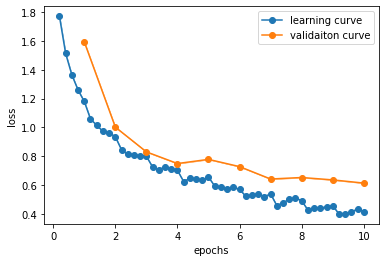

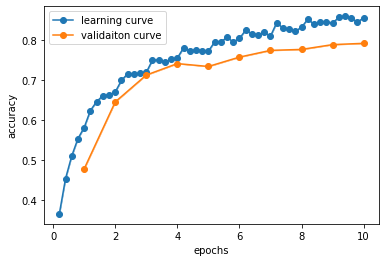

In [ ]:
plot_learning_curve(np.array(scores3))

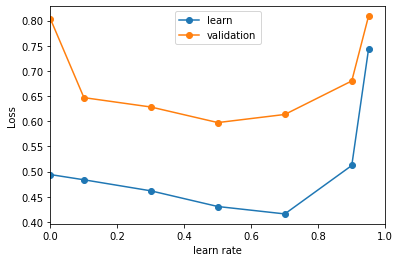

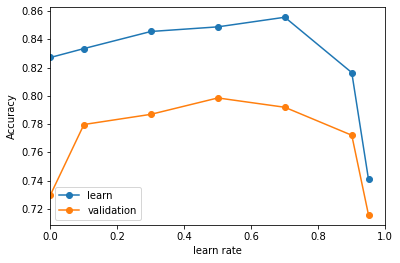

In [ ]:
scores4 = np.array([np.load(f"AlexNet_Aug_Norm-7_momentum_{m}.npy").tolist() for m in [0,0.1,0.3,0.5,0.7,0.9,0.95]])

plt.plot([0, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95], scores4[:,0,-1,-2,0], marker="o", label="learn")
plt.plot([0, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95], scores4[:,0,-1,-1,0], marker="o", label="validation")
#plt.xscale("log")
plt.xlim(0,1)
plt.xlabel("learn rate")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot([0, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95], scores4[:,0,-1,-2,1], marker="o", label="learn")
plt.plot([0, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95], scores4[:,0,-1,-1,1], marker="o", label="validation")
#plt.xscale("log")
plt.xlim(0,1)
plt.xlabel("learn rate")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## その他

#### LeNet, SGD, lr=0.001, momentum=0.9, batch=4

In [ ]:
scoresss = cross_validation(Net, {},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.001, "momentum":0.9},
                 batch_size=4, verbose_interbal=40000//4//10, epoch_size=5,
                 modelname="LeNet_batch4", device="cpu")

loop 1
  epoch 1 | 
    [1,  4000] loss: 2.2980, acc: 0.1120
    [1,  8000] loss: 2.1441, acc: 0.2070
    [1, 12000] loss: 1.9832, acc: 0.2642
    [1, 16000] loss: 1.8562, acc: 0.3005
    [1, 20000] loss: 1.7324, acc: 0.3535
    [1, 24000] loss: 1.6534, acc: 0.3985
    [1, 28000] loss: 1.6030, acc: 0.4135
    [1, 32000] loss: 1.5706, acc: 0.4275
    [1, 36000] loss: 1.5341, acc: 0.4370
    [1, 40000] loss: 1.5261, acc: 0.4435 | validation loss: 1.4929, acc: 0.4564
  epoch 2 | 
    [2,  4000] loss: 1.4641, acc: 0.4620
    [2,  8000] loss: 1.4465, acc: 0.4758
    [2, 12000] loss: 1.4406, acc: 0.4800
    [2, 16000] loss: 1.4209, acc: 0.4853
    [2, 20000] loss: 1.4103, acc: 0.4965
    [2, 24000] loss: 1.3769, acc: 0.5010
    [2, 28000] loss: 1.3772, acc: 0.5138
    [2, 32000] loss: 1.3758, acc: 0.4995
    [2, 36000] loss: 1.3065, acc: 0.5278
    [2, 40000] loss: 1.3215, acc: 0.5142 | validation loss: 1.3397, acc: 0.5184
  epoch 3 | 
    [3,  4000] loss: 1.2861, acc: 0.5477
    [3,  8000] 

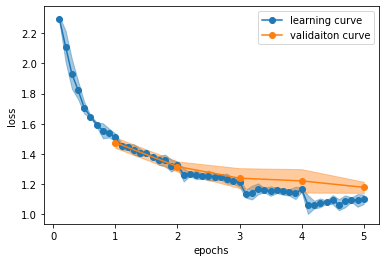

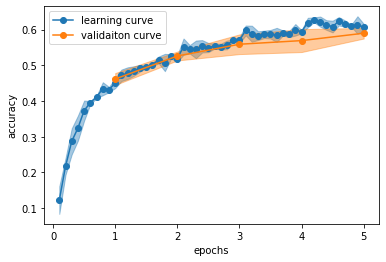

In [ ]:
plot_validation_curve(np.array(scoresss))

#### LeNet, SGD, lr=0.001, momentum=0.9, batch=32

In [ ]:
scoresss = cross_validation(Net, {},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.001, "momentum":0.9},
                 batch_size=32, verbose_interbal=40000//32//10, epoch_size=5,
                 repsize=3, modelname="LeNet_batch32", device="cpu")

loop 1
  epoch 1 | 
    [1,  4000] loss: 2.3047, acc: 0.0915
    [1,  8000] loss: 2.3021, acc: 0.1035
    [1, 12000] loss: 2.3007, acc: 0.1003
    [1, 16000] loss: 2.2977, acc: 0.1285
    [1, 20000] loss: 2.2934, acc: 0.1400
    [1, 24000] loss: 2.2855, acc: 0.1520
    [1, 28000] loss: 2.2688, acc: 0.1615
    [1, 32000] loss: 2.2448, acc: 0.1757
    [1, 36000] loss: 2.2103, acc: 0.1958
    [1, 40000] loss: 2.1601, acc: 0.2130 | validation loss: 2.1253, acc: 0.2365
  epoch 2 | 
    [2,  4000] loss: 2.1013, acc: 0.2380
    [2,  8000] loss: 2.0600, acc: 0.2370
    [2, 12000] loss: 2.0329, acc: 0.2445
    [2, 16000] loss: 2.0052, acc: 0.2565
    [2, 20000] loss: 1.9624, acc: 0.2807
    [2, 24000] loss: 1.9613, acc: 0.2720
    [2, 28000] loss: 1.9027, acc: 0.2928
    [2, 32000] loss: 1.8753, acc: 0.3125
    [2, 36000] loss: 1.8106, acc: 0.3372
    [2, 40000] loss: 1.7998, acc: 0.3415 | validation loss: 1.7730, acc: 0.3507
  epoch 3 | 
    [3,  4000] loss: 1.7579, acc: 0.3633
    [3,  8000] 

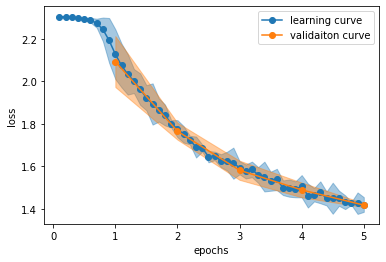

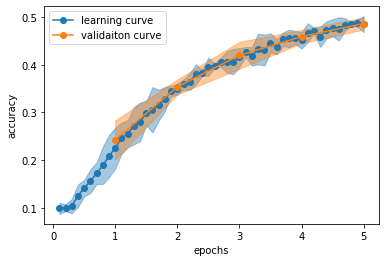

In [ ]:
plot_validation_curve(np.array(scoresss))

#### AlexNet, SGD, lr=0.001, momentum=0.9, weight_decay=4e-3, batch=32

In [ ]:
scoresss = cross_validation(MyAlexNet, {"num_classes":10},
                 nn.CrossEntropyLoss, {},
                 optim.SGD, {"lr": 0.001, "momentum":0.9, weight_decay=4e-3},
                 batch_size=32, minibatch=1024, epoch_size=5,
                 modelname="Alex_batch32", device="cpu")

loop 1
  epoch 1 | 
    validation loss: 2.2998, acc: 0.1550
  epoch 2 | 
    validation loss: 1.9348, acc: 0.2855
  epoch 3 | 
    validation loss: 1.6260, acc: 0.3940
  epoch 4 | 
    validation loss: 1.5126, acc: 0.4337
  epoch 5 | 
    validation loss: 1.3660, acc: 0.4988
loop 2
  epoch 1 | 
    validation loss: 2.2983, acc: 0.1353
  epoch 2 | 


In [ ]:
import pickle

#### AlexNet, SGD, lr=0.001, momentum=0.9, batch=4

In [ ]:
scoresss = cross_validation(MyAlexNet, {"num_classes":10},
                 nn.CrossEntropyLoss , {},
                 optim.SGD, {"lr": 0.001, "momentum":0.9},
                 batch_size=4, verbose_interbal=40000//4//10, epoch_size=5,
                 repsize=3, modelname="AlexNet_batch4_MSE", device="cuda:0")

loop 1
  epoch 1 | 
    [1,  4000] loss: 2.3026, acc: 0.1017
    [1,  8000] loss: 2.2972, acc: 0.1305
    [1, 12000] loss: 2.1158, acc: 0.2090
    [1, 16000] loss: 1.9287, acc: 0.2883
    [1, 20000] loss: 1.7840, acc: 0.3342
    [1, 24000] loss: 1.7364, acc: 0.3613
    [1, 28000] loss: 1.6422, acc: 0.3777
    [1, 32000] loss: 1.5982, acc: 0.4078
    [1, 36000] loss: 1.5328, acc: 0.4328
    [1, 40000] loss: 1.4907, acc: 0.4522 | validation loss: 1.4422, acc: 0.4639
  epoch 2 | 
    [2,  4000] loss: 1.4398, acc: 0.4750
    [2,  8000] loss: 1.3895, acc: 0.4870
    [2, 12000] loss: 1.3639, acc: 0.4900
    [2, 16000] loss: 1.3633, acc: 0.4998
    [2, 20000] loss: 1.2949, acc: 0.5238
    [2, 24000] loss: 1.2526, acc: 0.5353
    [2, 28000] loss: 1.2656, acc: 0.5325
    [2, 32000] loss: 1.1981, acc: 0.5703
    [2, 36000] loss: 1.1725, acc: 0.5775
    [2, 40000] loss: 1.1505, acc: 0.5825 | validation loss: 1.0788, acc: 0.6093
  epoch 3 | 
    [3,  4000] loss: 1.0872, acc: 0.6098
    [3,  8000] 

↑CELのまちがい

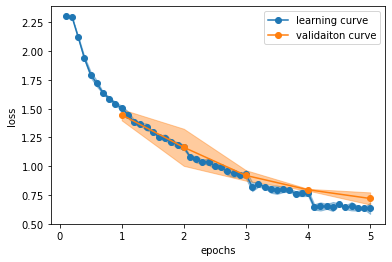

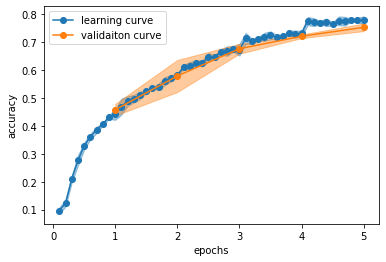

In [ ]:
plot_validation_curve(np.array(scoresss))

In [ ]:
np.save("AlexNet_batch4_CEL.npy", np.array(scoresss))

#### AlexNet, SGD, lr=0.001, momentum=0.9, batch=32

In [ ]:
scoresss = cross_validation(MyAlexNet, {"num_classes":10},
                 nn.CrossEntropyLoss , {},
                 optim.SGD, {"lr": 0.001, "momentum":0.9},
                 batch_size=32, verbose_interbal=40000//32//10, epoch_size=5,
                 repsize=3, modelname="AlexNet_batch32_CEL", device="cuda:0")

loop 1
  epoch 1 | 
    [1,  4000] loss: 2.3025, acc: 0.0935
    [1,  8000] loss: 2.3030, acc: 0.0938
    [1, 12000] loss: 2.3023, acc: 0.1070
    [1, 16000] loss: 2.3022, acc: 0.1115
    [1, 20000] loss: 2.3021, acc: 0.0958
    [1, 24000] loss: 2.3021, acc: 0.1042
    [1, 28000] loss: 2.3013, acc: 0.1145
    [1, 32000] loss: 2.3015, acc: 0.0985
    [1, 36000] loss: 2.3010, acc: 0.1077
    [1, 40000] loss: 2.3004, acc: 0.1555 | validation loss: 2.2997, acc: 0.1404
  epoch 2 | 
    [2,  4000] loss: 2.2993, acc: 0.1388
    [2,  8000] loss: 2.2976, acc: 0.1447
    [2, 12000] loss: 2.2952, acc: 0.1623
    [2, 16000] loss: 2.2870, acc: 0.1500
    [2, 20000] loss: 2.2648, acc: 0.1485
    [2, 24000] loss: 2.2100, acc: 0.1817
    [2, 28000] loss: 2.1568, acc: 0.2208
    [2, 32000] loss: 2.0642, acc: 0.2385
    [2, 36000] loss: 2.0355, acc: 0.2392
    [2, 40000] loss: 1.9870, acc: 0.2712 | validation loss: 1.9942, acc: 0.2502
  epoch 3 | 
    [3,  4000] loss: 1.9729, acc: 0.2540
    [3,  8000] 

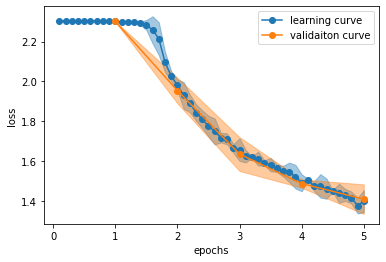

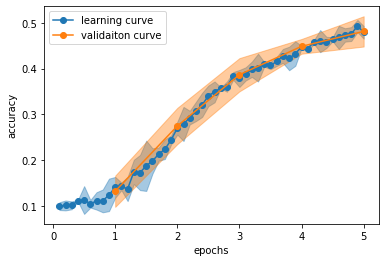

In [ ]:
np.save("AlexNet_batch32_CEL.npy", np.array(scoresss))
plot_validation_curve(np.array(scoresss))

### Adam

#### AlexNet, Adam, lr=0.001, betas=(0.9, 0.9), batch=4

In [ ]:
scoresss = cross_validation(MyAlexNet, {"num_classes":10},
                 nn.CrossEntropyLoss , {},
                 optim.Adam, {"lr": 0.001, "betas":(0.9, 0.9)},
                 batch_size=4, verbose_interbal=40000//4//10, epoch_size=5,
                 repsize=3, modelname="AlexNet_batch4_CEL_Adam", device="cuda:0")

loop 1
  epoch 1 | 
    [1,  4000] loss: 2.1206, acc: 0.1885
    [1,  8000] loss: 1.9257, acc: 0.2540
    [1, 12000] loss: 1.8466, acc: 0.3040
    [1, 16000] loss: 1.7579, acc: 0.3332
    [1, 20000] loss: 1.6765, acc: 0.3723
    [1, 24000] loss: 1.6825, acc: 0.3807
    [1, 28000] loss: 1.6622, acc: 0.3840
    [1, 32000] loss: 1.6656, acc: 0.3795
    [1, 36000] loss: 1.6145, acc: 0.4163
    [1, 40000] loss: 1.6128, acc: 0.4115 | validation loss: 1.7997, acc: 0.3950
  epoch 2 | 
    [2,  4000] loss: 1.6459, acc: 0.3960
    [2,  8000] loss: 1.5934, acc: 0.4220
    [2, 12000] loss: 1.6052, acc: 0.4338
    [2, 16000] loss: 1.6136, acc: 0.4255
    [2, 20000] loss: 1.6189, acc: 0.4155
    [2, 24000] loss: 1.6011, acc: 0.4325
    [2, 28000] loss: 1.6125, acc: 0.4208
    [2, 32000] loss: 1.6196, acc: 0.4308
    [2, 36000] loss: 1.6268, acc: 0.4380
    [2, 40000] loss: 1.6733, acc: 0.4150 | validation loss: 1.6960, acc: 0.4100
  epoch 3 | 
    [3,  4000] loss: 1.6270, acc: 0.4385
    [3,  8000] 

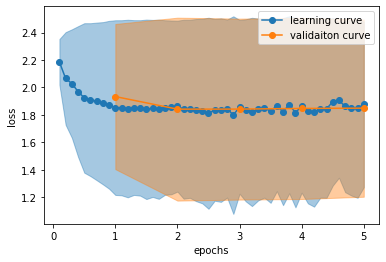

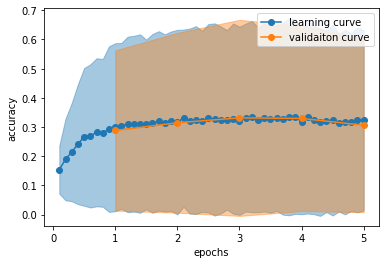

In [ ]:
np.save("AlexNet_batch4_CEL_Adam.npy", np.array(scoresss))
plot_validation_curve(np.array(scoresss))

### AlexNet 変種

In [ ]:
class AlexNet2(nn.Module):
  def __init__(self, num_classes=1000):
    super(AlexNet2, self).__init__()
    self.num_classes = 1000

    self.relu = F.relu
    self.pool = nn.MaxPool2d(2)
    
    self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)

    self.fc1 = nn.Linear(256 * 4 * 4, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, num_classes)
 
  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = self.relu(x)
    x = self.conv4(x)
    x = self.relu(x)
    x = self.conv4(x)
    x = self.relu(x)
    x = self.conv5(x)
    x = self.relu(x)
    x = self.pool(x)
    x = x.view(-1, self.num_flat_features(x))
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x
 
  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


In [ ]:
from torchsummary import summary
model = AlexNet2()
model = model.to("cuda:0")
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,688
         MaxPool2d-2           [-1, 96, 16, 16]               0
            Conv2d-3          [-1, 256, 16, 16]         614,656
         MaxPool2d-4            [-1, 256, 8, 8]               0
            Conv2d-5            [-1, 384, 8, 8]         885,120
            Conv2d-6            [-1, 384, 8, 8]       1,327,488
            Conv2d-7            [-1, 384, 8, 8]       1,327,488
            Conv2d-8            [-1, 256, 8, 8]         884,992
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Linear-10                 [-1, 4096]      16,781,312
           Linear-11                 [-1, 1000]       4,097,000
Total params: 25,920,744
Trainable params: 25,920,744
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Fo

#### AlexNet2, SDG, lr=0.001, momentum=0.9, batch=4

In [ ]:
scoresss = cross_validation(AlexNet2, {"num_classes":10},
                 nn.CrossEntropyLoss , {},
                 optim.SGD, {"lr": 0.001, "momentum":0.9},
                 batch_size=4, verbose_interbal=40000//4//10, epoch_size=5,
                 repsize=3, modelname="AlexNet2_batch4_CEL", device="cuda:0")

loop 1
  epoch 1 | 
    [1,  4000] loss: 2.3022, acc: 0.0953
    [1,  8000] loss: 2.3015, acc: 0.1080
    [1, 12000] loss: 2.1800, acc: 0.1777
    [1, 16000] loss: 1.9973, acc: 0.2515
    [1, 20000] loss: 1.8437, acc: 0.2960
    [1, 24000] loss: 1.7553, acc: 0.3402
    [1, 28000] loss: 1.6534, acc: 0.3852
    [1, 32000] loss: 1.6030, acc: 0.4000
    [1, 36000] loss: 1.5488, acc: 0.4235
    [1, 40000] loss: 1.5114, acc: 0.4360 | validation loss: 1.5441, acc: 0.4226
  epoch 2 | 
    [2,  4000] loss: 1.4655, acc: 0.4637
    [2,  8000] loss: 1.4081, acc: 0.4748
    [2, 12000] loss: 1.3854, acc: 0.4855
    [2, 16000] loss: 1.3380, acc: 0.5110
    [2, 20000] loss: 1.3214, acc: 0.5228
    [2, 24000] loss: 1.2858, acc: 0.5268
    [2, 28000] loss: 1.2386, acc: 0.5613
    [2, 32000] loss: 1.2229, acc: 0.5545
    [2, 36000] loss: 1.1789, acc: 0.5713
    [2, 40000] loss: 1.1591, acc: 0.5907 | validation loss: 1.1830, acc: 0.5742
  epoch 3 | 
    [3,  4000] loss: 1.1066, acc: 0.5988
    [3,  8000] 

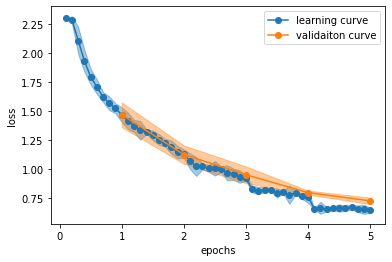

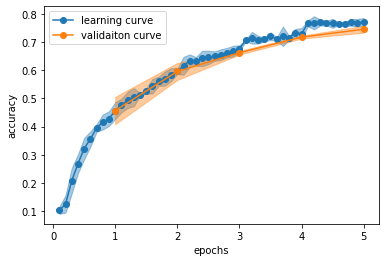

In [ ]:
np.save("AlexNet2_batch4_CEL.npy", np.array(scoresss))
plot_validation_curve(np.array(scoresss))

### AlexNet 変種2

In [ ]:
class AlexNet3(nn.Module):
  def __init__(self, num_classes=1000):
    super(AlexNet3, self).__init__()
    self.num_classes = num_classes

    self.relu = F.relu
    self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
    
    self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(96, 256, kernel_size=3, padding=2)
    self.conv3 = nn.Conv2d(256, 384, kernel_size=2, padding=1)
    self.conv4 = nn.Conv2d(384, 384, kernel_size=2, padding=1)
    self.conv5 = nn.Conv2d(384, 256, kernel_size=2, padding=1, )

    self.fc1 = nn.Linear(256 * (2 + 1) **2, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, num_classes)
 
  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = self.relu(x)
    x = self.conv4(x)
    x = self.relu(x)
    x = self.conv5(x)
    x = self.relu(x)
    x = self.pool(x)
    x = x.view(-1, self.num_flat_features(x))
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x
 
  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


In [ ]:
from torchsummary import summary
model = AlexNet3()
model = model.to("cuda:0")
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           2,688
         MaxPool2d-2             [-1, 96, 7, 7]               0
            Conv2d-3            [-1, 256, 9, 9]         221,440
         MaxPool2d-4            [-1, 256, 4, 4]               0
            Conv2d-5            [-1, 384, 5, 5]         393,600
            Conv2d-6            [-1, 384, 6, 6]         590,208
            Conv2d-7            [-1, 256, 7, 7]         393,472
         MaxPool2d-8            [-1, 256, 3, 3]               0
            Linear-9                 [-1, 4096]       9,441,280
           Linear-10                 [-1, 4096]      16,781,312
           Linear-11                 [-1, 1000]       4,097,000
Total params: 31,921,000
Trainable params: 31,921,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Fo

#### AlexNet2, SDG, lr=0.001, momentum=0.9, batch=4

In [ ]:
scoresss = cross_validation(AlexNet3, {"num_classes":10},
                 nn.CrossEntropyLoss , {},
                 optim.SGD, {"lr": 0.001, "momentum":0.9},
                 batch_size=4, verbose_interbal=40000//4//10, epoch_size=2,
                 repsize=1, modelname="AlexNet3_batch4_CEL", device="cuda:0")

loop 1
  epoch 1 | 
    [1,  4000] loss: 2.3022, acc: 0.0998
    [1,  8000] loss: 2.3003, acc: 0.1130
    [1, 12000] loss: 2.2561, acc: 0.1578
    [1, 16000] loss: 2.0538, acc: 0.2195
    [1, 20000] loss: 1.9020, acc: 0.2725
    [1, 24000] loss: 1.8119, acc: 0.3160
    [1, 28000] loss: 1.7580, acc: 0.3377
    [1, 32000] loss: 1.6797, acc: 0.3635
    [1, 36000] loss: 1.6623, acc: 0.3593
    [1, 40000] loss: 1.6049, acc: 0.3870 | validation loss: 1.6150, acc: 0.3911
  epoch 2 | 
    [2,  4000] loss: 1.5648, acc: 0.4128
    [2,  8000] loss: 1.5378, acc: 0.4185
    [2, 12000] loss: 1.5161, acc: 0.4405
    [2, 16000] loss: 1.4694, acc: 0.4482
    [2, 20000] loss: 1.4352, acc: 0.4600
    [2, 24000] loss: 1.4549, acc: 0.4555
    [2, 28000] loss: 1.4121, acc: 0.4830
    [2, 32000] loss: 1.3847, acc: 0.4923
    [2, 36000] loss: 1.3209, acc: 0.5092
    [2, 40000] loss: 1.3330, acc: 0.5150 | validation loss: 1.3311, acc: 0.5143


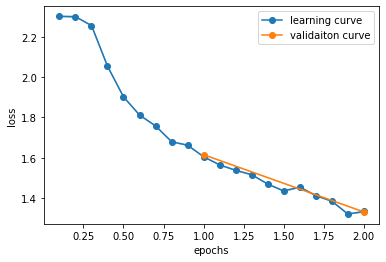

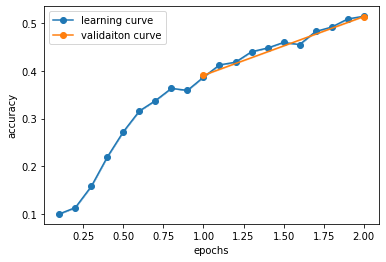

In [ ]:
np.save("AlexNet3_batch4_CEL.npy", np.array(scoresss))
plot_validation_curve(np.array(scoresss))

### MishとDropout導入

In [ ]:
class AlexNet_Mish_DO(nn.Module):
  def __init__(self, num_classes=1000, dropout_ratio=0.2):
    super(self.__class__, self).__init__()
    self.num_classes = num_classes

    #self.relu = F.relu
    self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
    
    self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(96, 256, kernel_size=3, padding=2)
    self.conv3 = nn.Conv2d(256, 384, kernel_size=2, padding=1)
    self.conv4 = nn.Conv2d(384, 384, kernel_size=2, padding=1)
    self.conv5 = nn.Conv2d(384, 256, kernel_size=2, padding=1, )

    self.fc1 = nn.Linear(256 * (2 + 1) **2, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, num_classes)
    
    self.dropout = nn.Dropout2d(p=dropout_ratio)

  def mish(self, x):
    return x * (F.softplus(x)).tanh()
 
  def forward(self, x):
    x = self.conv1(x)
    x = self.mish(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.mish(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = self.mish(x)
    x = self.conv4(x)
    x = self.mish(x)
    x = self.conv5(x)
    x = self.mish(x)
    x = self.pool(x)
    x = x.view(-1, self.num_flat_features(x))
    x = self.fc1(x)
    x = self.mish(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.mish(x)
    x = self.dropout(x)
    x = self.fc3(x)
    return x
 
  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


In [ ]:
from torchsummary import summary
model = AlexNet_Mish_DO(num_classes=10, dropout_ratio=0).to("cuda:0")
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           2,688
         MaxPool2d-2             [-1, 96, 7, 7]               0
            Conv2d-3            [-1, 256, 9, 9]         221,440
         MaxPool2d-4            [-1, 256, 4, 4]               0
            Conv2d-5            [-1, 384, 5, 5]         393,600
            Conv2d-6            [-1, 384, 6, 6]         590,208
            Conv2d-7            [-1, 256, 7, 7]         393,472
         MaxPool2d-8            [-1, 256, 3, 3]               0
            Linear-9                 [-1, 4096]       9,441,280
        Dropout2d-10                 [-1, 4096]               0
           Linear-11                 [-1, 4096]      16,781,312
        Dropout2d-12                 [-1, 4096]               0
           Linear-13                   [-1, 10]          40,970
Total params: 27,864,970
Trainable para

#### AlexNet_Mish, SDG, lr=0.001, momentum=0.9, batch=4

In [ ]:
scoresss = cross_validation(AlexNet_Mish_DO, {"num_classes":10, "dropout_ratio":0},
                 nn.CrossEntropyLoss , {},
                 optim.SGD, {"lr": 0.001, "momentum":0.9},
                 batch_size=4, verbose_interbal=40000//4//10, epoch_size=2,
                 repsize=1, modelname="Mish_batch4_CEL", device="cuda:0")

loop 1
  epoch 1 | 
    [1,  4000] loss: 2.3033, acc: 0.1008
    [1,  8000] loss: 2.3029, acc: 0.1067
    [1, 12000] loss: 2.3036, acc: 0.0943
    [1, 16000] loss: 2.3035, acc: 0.0985
    [1, 20000] loss: 2.3033, acc: 0.1040
    [1, 24000] loss: 2.3033, acc: 0.0968
    [1, 28000] loss: 2.3028, acc: 0.1022
    [1, 32000] loss: 2.3027, acc: 0.0993
    [1, 36000] loss: 2.3017, acc: 0.1118
    [1, 40000] loss: 2.2992, acc: 0.1158 | validation loss: 2.2940, acc: 0.1372
  epoch 2 | 
    [2,  4000] loss: 2.2597, acc: 0.1482
    [2,  8000] loss: 2.1708, acc: 0.1908
    [2, 12000] loss: 2.0776, acc: 0.2140
    [2, 16000] loss: 2.0124, acc: 0.2290
    [2, 20000] loss: 1.9541, acc: 0.2480
    [2, 24000] loss: 1.8826, acc: 0.2740
    [2, 28000] loss: 1.8252, acc: 0.3123
    [2, 32000] loss: 1.7809, acc: 0.3115
    [2, 36000] loss: 1.7487, acc: 0.3427
    [2, 40000] loss: 1.7024, acc: 0.3520 | validation loss: 1.6907, acc: 0.3434


#### AlexNet_Mish, SDG, lr=0.005, momentum=0.9, batch=4

In [ ]:
scoresss = cross_validation(AlexNet_Mish_DO, {"num_classes":10, "dropout_ratio":0},
                 nn.CrossEntropyLoss , {},
                 optim.SGD, {"lr": 0.005, "momentum":0.9},
                 batch_size=4, verbose_interbal=40000//4//10, epoch_size=2,
                 repsize=1, modelname="Mish_batch4_CEL_lr0.005", device="cuda:0")

loop 1
  epoch 1 | 
    [1,  4000] loss: 2.3063, acc: 0.1008
    [1,  8000] loss: 2.3055, acc: 0.1027
    [1, 12000] loss: 2.2133, acc: 0.1585
    [1, 16000] loss: 1.9846, acc: 0.2432
    [1, 20000] loss: 1.8051, acc: 0.3115
    [1, 24000] loss: 1.7153, acc: 0.3623
    [1, 28000] loss: 1.6342, acc: 0.3950
    [1, 32000] loss: 1.5912, acc: 0.4085
    [1, 36000] loss: 1.5362, acc: 0.4238
    [1, 40000] loss: 1.4637, acc: 0.4788 | validation loss: 1.4634, acc: 0.4536
  epoch 2 | 
    [2,  4000] loss: 1.4089, acc: 0.4948
    [2,  8000] loss: 1.3664, acc: 0.5000
    [2, 12000] loss: 1.3596, acc: 0.5098
    [2, 16000] loss: 1.3329, acc: 0.5218
    [2, 20000] loss: 1.2857, acc: 0.5400
    [2, 24000] loss: 1.2760, acc: 0.5387
    [2, 28000] loss: 1.2523, acc: 0.5627
    [2, 32000] loss: 1.2095, acc: 0.5645
    [2, 36000] loss: 1.1707, acc: 0.5847
    [2, 40000] loss: 1.1609, acc: 0.5857 | validation loss: 1.1749, acc: 0.5857


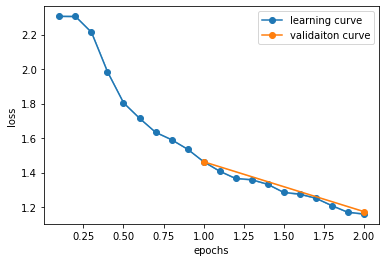

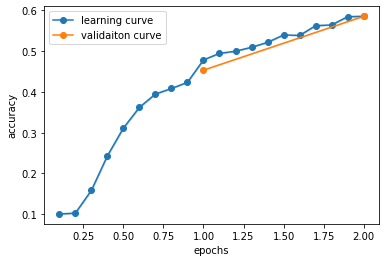

In [ ]:
np.save("Mish_batch4_CEL_lr0.005.npy", np.array(scoresss))
plot_validation_curve(np.array(scoresss))

#### AlexNet_Mish, dropout=0.1, SDG, lr=0.005, momentum=0.9, batch=4

In [ ]:
scoresss = cross_validation(AlexNet_Mish_DO, {"num_classes":10, "dropout_ratio":0.1},
                 nn.CrossEntropyLoss , {},
                 optim.SGD, {"lr": 0.01, "momentum":0.9},
                 batch_size=4, verbose_interbal=40000//4//10, epoch_size=10,
                 repsize=1, modelname="Mish_batch4_CEL_lr0.01_DO_0.1", device="cuda:0")

loop 1
  epoch 1 | 
    [1,  4000] loss: 2.3079, acc: 0.1020
    [1,  8000] loss: 2.1220, acc: 0.1872
    [1, 12000] loss: 1.8715, acc: 0.2772
    [1, 16000] loss: 1.7495, acc: 0.3390
    [1, 20000] loss: 1.6779, acc: 0.3762
    [1, 24000] loss: 1.6136, acc: 0.4075
    [1, 28000] loss: 1.5977, acc: 0.4073
    [1, 32000] loss: 1.5567, acc: 0.4323
    [1, 36000] loss: 1.5082, acc: 0.4570
    [1, 40000] loss: 1.4959, acc: 0.4567 | validation loss: 1.5600, acc: 0.4486
  epoch 2 | 
    [2,  4000] loss: 1.4463, acc: 0.4858
    [2,  8000] loss: 1.4303, acc: 0.4993
    [2, 12000] loss: 1.3873, acc: 0.5088
    [2, 16000] loss: 1.4269, acc: 0.4928
    [2, 20000] loss: 1.4011, acc: 0.4950
    [2, 24000] loss: 1.3845, acc: 0.5082
    [2, 28000] loss: 1.4278, acc: 0.4970
    [2, 32000] loss: 1.4192, acc: 0.5065
    [2, 36000] loss: 1.4296, acc: 0.5025
    [2, 40000] loss: 1.4508, acc: 0.5032 | validation loss: 1.4685, acc: 0.4959
  epoch 3 | 
    [3,  4000] loss: 1.4178, acc: 0.5138
    [3,  8000] 

KeyboardInterrupt: ignored

In [ ]:
np.save("Mish_batch4_CEL_lr0.01_DO_0.1.npy", np.array(scoresss))
plot_validation_curve(np.array(scoresss))

### AlexNet その3 全結合層を深く,Mish

In [ ]:
class AlexNet_Mish_DO_2(nn.Module):
  def __init__(self, num_classes=1000, dropout_ratio=0.2):
    super(self.__class__, self).__init__()
    self.num_classes = num_classes

    #self.relu = F.relu
    self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
    
    self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(96, 256, kernel_size=3, padding=2)
    self.conv3 = nn.Conv2d(256, 384, kernel_size=2, padding=1)
    self.conv4 = nn.Conv2d(384, 384, kernel_size=2, padding=1)
    self.conv5 = nn.Conv2d(384, 256, kernel_size=2, padding=1, )

    self.fc1 = nn.Linear(256 * (2 + 1) **2, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc2_2 = nn.Linear(4096, 4096)
    self.fc2_3 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, num_classes)
    
    self.dropout = nn.Dropout2d(p=dropout_ratio)

  def mish(self, x):
    return x * (F.softplus(x)).tanh()
 
  def forward(self, x):
    x = self.conv1(x)
    x = self.mish(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.mish(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = self.mish(x)
    x = self.conv4(x)
    x = self.mish(x)
    x = self.conv5(x)
    x = self.mish(x)
    x = self.pool(x)
    x = x.view(-1, self.num_flat_features(x))
    x = self.fc1(x)
    x = self.mish(x)
    x = self.fc2(x)
    x = self.mish(x)
    x = self.fc2_2(x)
    x = self.mish(x)
    x = self.fc2_3(x)
    x = self.mish(x)
    x = self.fc3(x)
    return x
 
  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


In [ ]:
model = AlexNet_Mish_DO_2(num_classes=10, dropout_ratio=0).to("cuda:0")
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           2,688
         MaxPool2d-2             [-1, 96, 7, 7]               0
            Conv2d-3            [-1, 256, 9, 9]         221,440
         MaxPool2d-4            [-1, 256, 4, 4]               0
            Conv2d-5            [-1, 384, 5, 5]         393,600
            Conv2d-6            [-1, 384, 6, 6]         590,208
            Conv2d-7            [-1, 256, 7, 7]         393,472
         MaxPool2d-8            [-1, 256, 3, 3]               0
            Linear-9                 [-1, 4096]       9,441,280
           Linear-10                 [-1, 4096]      16,781,312
           Linear-11                 [-1, 4096]      16,781,312
           Linear-12                 [-1, 4096]      16,781,312
           Linear-13                   [-1, 10]          40,970
Total params: 61,427,594
Trainable para

#### AlexNet_Mish2, SDG, lr=0.005, momentum=0.9, batch=4

In [ ]:
scoresss = cross_validation(AlexNet_Mish_DO, {"num_classes":10, "dropout_ratio":0},
                 nn.CrossEntropyLoss , {},
                 optim.SGD, {"lr": 0.01, "momentum":0.9},
                 batch_size=4, verbose_interbal=40000//4//10, epoch_size=10,
                 repsize=1, modelname="Mish2_batch4_CEL_lr0.01", device="cuda:0")

loop 1
  epoch 1 | 
    [1,  4000] loss: 2.3095, acc: 0.1017
    [1,  8000] loss: 2.1548, acc: 0.1730
    [1, 12000] loss: 1.9150, acc: 0.2700
    [1, 16000] loss: 1.7743, acc: 0.3295
    [1, 20000] loss: 1.7327, acc: 0.3372
    [1, 24000] loss: 1.6625, acc: 0.3850
    [1, 28000] loss: 1.5832, acc: 0.4085
    [1, 32000] loss: 1.5537, acc: 0.4360
    [1, 36000] loss: 1.5144, acc: 0.4517
    [1, 40000] loss: 1.4918, acc: 0.4600 | validation loss: 1.5203, acc: 0.4394
  epoch 2 | 
    [2,  4000] loss: 1.4405, acc: 0.4798
    [2,  8000] loss: 1.4291, acc: 0.4868
    [2, 12000] loss: 1.4291, acc: 0.5012
    [2, 16000] loss: 1.4066, acc: 0.4980
    [2, 20000] loss: 1.3726, acc: 0.5120
    [2, 24000] loss: 1.3785, acc: 0.5218
    [2, 28000] loss: 1.3587, acc: 0.5228
    [2, 32000] loss: 1.3802, acc: 0.5150
    [2, 36000] loss: 1.3419, acc: 0.5285
    [2, 40000] loss: 1.3302, acc: 0.5387 | validation loss: 1.2854, acc: 0.5642
  epoch 3 | 
    [3,  4000] loss: 1.3113, acc: 0.5530
    [3,  8000] 

#### AlexNet_Mish, SDG, lr=0.01, momentum=0.9, batch=4

In [ ]:
scoresss = cross_validation(AlexNet_Mish_DO_2, {"num_classes":10, "dropout_ratio":0},
                 nn.CrossEntropyLoss , {},
                 optim.SGD, {"lr": 0.01, "momentum":0.9},
                 batch_size=4, verbose_interbal=40000//4//10, epoch_size=10,
                 repsize=3, modelname="Mish2_batch4_CEL_lr0.01-2", device="cuda:0")

loop 1
  epoch 1 | 
    [1,  4000] loss: 2.3081, acc: 0.0983
    [1,  8000] loss: 2.3088, acc: 0.1045
    [1, 12000] loss: 2.3100, acc: 0.1000
    [1, 16000] loss: 2.3091, acc: 0.1025
    [1, 20000] loss: 2.3083, acc: 0.1013
    [1, 24000] loss: 2.3090, acc: 0.1010
    [1, 28000] loss: 2.3078, acc: 0.1005
    [1, 32000] loss: 2.3047, acc: 0.1025
    [1, 36000] loss: 2.1597, acc: 0.1777
    [1, 40000] loss: 1.9892, acc: 0.2213 | validation loss: 1.8820, acc: 0.2468
  epoch 2 | 
    [2,  4000] loss: 1.8729, acc: 0.2622
    [2,  8000] loss: 1.7980, acc: 0.3195
    [2, 12000] loss: 1.7337, acc: 0.3257
    [2, 16000] loss: 1.6847, acc: 0.3525
    [2, 20000] loss: 1.6514, acc: 0.3757
    [2, 24000] loss: 1.6308, acc: 0.3922
    [2, 28000] loss: 1.5701, acc: 0.4080
    [2, 32000] loss: 1.5673, acc: 0.4158
    [2, 36000] loss: 1.5546, acc: 0.4320
    [2, 40000] loss: 1.4925, acc: 0.4490 | validation loss: 1.6286, acc: 0.4413
  epoch 3 | 
    [3,  4000] loss: 1.4759, acc: 0.4602
    [3,  8000] 

KeyboardInterrupt: ignored

### AlexNet + Mish + Skip connection

In [ ]:
class AlexNet_Mish_DO_skip(nn.Module):
  def __init__(self, num_classes=1000, dropout_ratio=0.2):
    super(self.__class__, self).__init__()
    self.num_classes = num_classes

    #self.relu = F.relu
    self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
    
    self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(96, 256, kernel_size=3, padding=2)
    self.conv3 = nn.Conv2d(256, 384, kernel_size=2, padding=1)
    self.conv14 = nn.Conv2d(96, 384, kernel_size=3, stride=2, padding=2)
    self.conv4 = nn.Conv2d(384, 384, kernel_size=2, padding=1)
    self.conv25 = nn.Conv2d(256, 384, kernel_size=3, padding=2)
    self.conv5 = nn.Conv2d(384, 256, kernel_size=2, padding=1, )

    self.fc1 = nn.Linear(256 * (2 + 1) **2, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc2_2 = nn.Linear(4096, 4096)
    self.fc2_3 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, num_classes)
    
    self.dropout = nn.Dropout2d(p=dropout_ratio)

  def mish(self, x):
    return x * (F.softplus(x)).tanh()
 
  def forward(self, x):
    x = self.conv1(x)
    x = self.mish(x)
    x1 = self.pool(x)
    x = self.conv2(x1)
    x = self.mish(x)
    x2 = self.pool(x)
    x = self.conv3(x2)
    x = self.mish(x)
    x1 = self.conv14(x1)
    x1 = self.mish(x1)
    x = self.conv4(x + x1)
    x = self.mish(x)
    x2 = self.conv25(x2)
    x2 = self.mish(x2)
    x = self.conv5(x + x2)
    x = self.mish(x)
    x = self.pool(x)
    x = x.view(-1, self.num_flat_features(x))
    x = self.fc1(x)
    x1 = self.mish(x)
    x = self.fc2(x1)
    x2 = self.mish(x)
    x = self.fc2_2(x2)
    x = self.mish(x)
    x = self.fc2_3(x + x1)
    x = self.mish(x)
    x = self.fc3(x + x2)
    return x
 
  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


In [ ]:
from torchsummary import summary
model = AlexNet_Mish_DO_skip()
model = model.to("cuda:0")
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           2,688
         MaxPool2d-2             [-1, 96, 7, 7]               0
            Conv2d-3            [-1, 256, 9, 9]         221,440
         MaxPool2d-4            [-1, 256, 4, 4]               0
            Conv2d-5            [-1, 384, 5, 5]         393,600
            Conv2d-6            [-1, 384, 5, 5]         332,160
            Conv2d-7            [-1, 384, 6, 6]         590,208
            Conv2d-8            [-1, 384, 6, 6]         885,120
            Conv2d-9            [-1, 256, 7, 7]         393,472
        MaxPool2d-10            [-1, 256, 3, 3]               0
           Linear-11                 [-1, 4096]       9,441,280
           Linear-12                 [-1, 4096]      16,781,312
           Linear-13                 [-1, 4096]      16,781,312
           Linear-14                 [-

#### AlexNet+Mish+Skip, SDG, lr=0.01, momentum=0.9, batch=4

In [ ]:
scoresss = cross_validation(AlexNet_Mish_DO_skip, {"num_classes":10, "dropout_ratio":0},
                 nn.CrossEntropyLoss , {},
                 optim.SGD, {"lr": 0.01, "momentum":0.9},
                 batch_size=4, verbose_interbal=40000//4//10, epoch_size=10,
                 repsize=1, modelname="Mish_skip_batch4_CEL_lr0.01", device="cuda:0")

loop 1
  epoch 1 | 
    [1,  4000] loss: 2.1767, acc: 0.1655
    [1,  8000] loss: 1.8691, acc: 0.2913
    [1, 12000] loss: 1.7084, acc: 0.3568
    [1, 16000] loss: 1.6337, acc: 0.3950
    [1, 20000] loss: 1.5684, acc: 0.4250
    [1, 24000] loss: 1.5319, acc: 0.4472
    [1, 28000] loss: 1.4577, acc: 0.4738
    [1, 32000] loss: 1.4533, acc: 0.4870
    [1, 36000] loss: 1.4305, acc: 0.4888
    [1, 40000] loss: 1.4026, acc: 0.5055 | validation loss: 1.2753, acc: 0.5469
  epoch 2 | 
    [2,  4000] loss: 1.3976, acc: 0.5012
    [2,  8000] loss: 1.4111, acc: 0.5010

KeyboardInterrupt: ignored

In [ ]:
np.save("Mish_skip_batch4_CEL_lr0.01.npy", np.array(scoresss))
plot_validation_curve(np.array(scoresss))

### 生AlexNet, optim param 探索

In [ ]:
mynet = MyAlexNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mynet.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train(mynet, criterion, optimizer, 2)

[1,  2000] loss: 2.302
[1,  4000] loss: 2.077
[1,  6000] loss: 1.782
[1,  8000] loss: 1.635
[1, 10000] loss: 1.544
[1, 12000] loss: 1.431
[2,  2000] loss: 1.352
[2,  4000] loss: 1.285
[2,  6000] loss: 1.210
[2,  8000] loss: 1.171
[2, 10000] loss: 1.090
[2, 12000] loss: 1.065
Finished Training


In [ ]:
test(mynet)

Accuracy of the network on the 10000 test images: 65 %


In [ ]:
torch.save(mynet.state_dict(), "./AlexNet_default.pth")

In [ ]:
mynet = MyAlexNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mynet.parameters(), lr=0.001, momentum=0.9)

mynet = train(mynet, criterion, optimizer, 1)
test(mynet)
torch.save(mynet.state_dict(), "./AlexNet_default1.pth")

[1,  2000] loss: 2.301
[1,  4000] loss: 2.053
[1,  6000] loss: 1.781
[1,  8000] loss: 1.636
[1, 10000] loss: 1.526
[1, 12000] loss: 1.457
Finished Training
Accuracy of the network on the 10000 test images: 49 %


In [ ]:
mynet = MyAlexNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mynet.parameters(), lr=0.001, momentum=0.9)

mynet = train(mynet, criterion, optimizer, 5)
test(mynet)
torch.save(mynet.state_dict(), "./AlexNet_default5.pth")

[1,  2000] loss: 2.298
[1,  4000] loss: 1.990
[1,  6000] loss: 1.737
[1,  8000] loss: 1.602
[1, 10000] loss: 1.496
[1, 12000] loss: 1.415
[2,  2000] loss: 1.299
[2,  4000] loss: 1.253
[2,  6000] loss: 1.191
[2,  8000] loss: 1.136
[2, 10000] loss: 1.092
[2, 12000] loss: 1.042
[3,  2000] loss: 0.949
[3,  4000] loss: 0.917
[3,  6000] loss: 0.888
[3,  8000] loss: 0.861
[3, 10000] loss: 0.844
[3, 12000] loss: 0.812
[4,  2000] loss: 0.721
[4,  4000] loss: 0.711
[4,  6000] loss: 0.694
[4,  8000] loss: 0.673
[4, 10000] loss: 0.684
[4, 12000] loss: 0.634
[5,  2000] loss: 0.554
[5,  4000] loss: 0.551
[5,  6000] loss: 0.552
[5,  8000] loss: 0.562
[5, 10000] loss: 0.541
[5, 12000] loss: 0.534
Finished Training
Accuracy of the network on the 10000 test images: 77 %


In [ ]:
mynet = MyAlexNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(mynet.parameters(), lr=0.001)

mynet = train(mynet, criterion, optimizer, 5)
test(mynet)
torch.save(mynet.state_dict(), "./AlexNet_adam_5.pth")

[1,  2000] loss: 2.303
[1,  4000] loss: 2.302
[1,  6000] loss: 2.302
[1,  8000] loss: 2.301
[1, 10000] loss: 2.301
[1, 12000] loss: 2.300
[2,  2000] loss: 2.298
[2,  4000] loss: 2.294
[2,  6000] loss: 2.281
[2,  8000] loss: 2.195
[2, 10000] loss: 2.040
[2, 12000] loss: 2.005
[3,  2000] loss: 1.954
[3,  4000] loss: 1.906
[3,  6000] loss: 1.869
[3,  8000] loss: 1.830
[3, 10000] loss: 1.808
[3, 12000] loss: 1.751
[4,  2000] loss: 1.733
[4,  4000] loss: 1.706
[4,  6000] loss: 1.701
[4,  8000] loss: 1.678
[4, 10000] loss: 1.660
[4, 12000] loss: 1.641
[5,  2000] loss: 1.620
[5,  4000] loss: 1.612
[5,  6000] loss: 1.623
[5,  8000] loss: 1.582
[5, 10000] loss: 1.595
[5, 12000] loss: 1.591
Finished Training
Accuracy of the network on the 10000 test images: 42 %


In [ ]:
mynet = MyAlexNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(mynet.parameters(), lr=0.01)

mynet = train(mynet, criterion, optimizer, 5)
test(mynet)
torch.save(mynet.state_dict(), "./AlexNet_adam_5_0.01.pth")

[1,  2000] loss: 2.300
[1,  4000] loss: 2.061
[1,  6000] loss: 1.821
[1,  8000] loss: 1.711
[1, 10000] loss: 1.616
[1, 12000] loss: 1.539
[2,  2000] loss: 1.448
[2,  4000] loss: 1.415
[2,  6000] loss: 1.382
[2,  8000] loss: 1.342
[2, 10000] loss: 1.306
[2, 12000] loss: 1.263
[3,  2000] loss: 1.200
[3,  4000] loss: 1.184
[3,  6000] loss: 1.133
[3,  8000] loss: 1.122
[3, 10000] loss: 1.091
[3, 12000] loss: 1.087
[4,  2000] loss: 1.012
[4,  4000] loss: 0.991
[4,  6000] loss: 0.981
[4,  8000] loss: 0.958
[4, 10000] loss: 0.940
[4, 12000] loss: 0.918
[5,  2000] loss: 0.864
[5,  4000] loss: 0.856
[5,  6000] loss: 0.847
[5,  8000] loss: 0.802
[5, 10000] loss: 0.838
[5, 12000] loss: 0.799
Finished Training
Accuracy of the network on the 10000 test images: 69 %


In [ ]:
mynet = MyAlexNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(mynet.parameters(), lr=0.1)

mynet = train(mynet, criterion, optimizer, 5)
test(mynet)
torch.save(mynet.state_dict(), "./AlexNet_adam_5_0.1.pth")

[1,  2000] loss: 2.029
[1,  4000] loss: 1.698
[1,  6000] loss: 1.529
[1,  8000] loss: 1.410
[1, 10000] loss: 1.296
[1, 12000] loss: 1.224
[2,  2000] loss: 1.120
[2,  4000] loss: 1.062
[2,  6000] loss: 1.042
[2,  8000] loss: 1.016
[2, 10000] loss: 0.989
[2, 12000] loss: 0.998
[3,  2000] loss: 0.911
[3,  4000] loss: 0.867
[3,  6000] loss: 0.912
[3,  8000] loss: 0.887
[3, 10000] loss: 0.892
[3, 12000] loss: 0.920
[4,  2000] loss: 0.834
[4,  4000] loss: 0.872
[4,  6000] loss: 0.907
[4,  8000] loss: 0.951
[4, 10000] loss: 0.932
[4, 12000] loss: 0.991
[5,  2000] loss: 0.925
[5,  4000] loss: 0.936
[5,  6000] loss: 1.022
[5,  8000] loss: 1.021
[5, 10000] loss: 1.090
[5, 12000] loss: 1.122
Finished Training
Accuracy of the network on the 10000 test images: 62 %


In [ ]:
mynet = MyAlexNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mynet.parameters(), lr=0.001)

mynet = train(mynet, criterion, optimizer, 5)
test(mynet)
torch.save(mynet.state_dict(), "./AlexNet_adamm_5_0.001.pth")

[1,  2000] loss: 2.307
[1,  4000] loss: 2.303
[1,  6000] loss: 2.303
[1,  8000] loss: 2.303
[1, 10000] loss: 2.303
[1, 12000] loss: 2.303
[2,  2000] loss: 2.303
[2,  4000] loss: 2.303
[2,  6000] loss: 2.303
[2,  8000] loss: 2.303
[2, 10000] loss: 2.303
[2, 12000] loss: 2.303
[3,  2000] loss: 2.303
[3,  4000] loss: 2.303
[3,  6000] loss: 2.303
[3,  8000] loss: 2.303
[3, 10000] loss: 2.303
[3, 12000] loss: 2.303
[4,  2000] loss: 2.303
[4,  4000] loss: 2.303
[4,  6000] loss: 2.303
[4,  8000] loss: 2.303
[4, 10000] loss: 2.303
[4, 12000] loss: 2.303
[5,  2000] loss: 2.303
[5,  4000] loss: 2.303
[5,  6000] loss: 2.303
[5,  8000] loss: 2.303
[5, 10000] loss: 2.303
[5, 12000] loss: 2.303
Finished Training
Accuracy of the network on the 10000 test images: 10 %


In [ ]:
mynet = MyAlexNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mynet.parameters(), lr=0.01)

mynet = train(mynet, criterion, optimizer, 5)
test(mynet)
torch.save(mynet.state_dict(), "./AlexNet_adamm_5_0.01.pth")

[1,  2000] loss: 976.110
[1,  4000] loss: 2.307
[1,  6000] loss: 2.307
[1,  8000] loss: 2.306
[1, 10000] loss: 2.306
[1, 12000] loss: 2.306
[2,  2000] loss: 2.306
[2,  4000] loss: 2.306
[2,  6000] loss: 2.306
[2,  8000] loss: 2.306
[2, 10000] loss: 2.307
[2, 12000] loss: 2.307
[3,  2000] loss: 2.307
[3,  4000] loss: 2.306
[3,  6000] loss: 2.306
[3,  8000] loss: 2.307
[3, 10000] loss: 2.307
[3, 12000] loss: 2.306
[4,  2000] loss: 2.307
[4,  4000] loss: 2.307
[4,  6000] loss: 2.306
[4,  8000] loss: 2.306
[4, 10000] loss: 2.306
[4, 12000] loss: 2.307
[5,  2000] loss: 2.308
[5,  4000] loss: 2.307
[5,  6000] loss: 2.306
[5,  8000] loss: 2.306
[5, 10000] loss: 2.306
[5, 12000] loss: 2.307
Finished Training
Accuracy of the network on the 10000 test images: 10 %


In [ ]:
mynet = MyAlexNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mynet.parameters(), lr=0.1)

mynet = train(mynet, criterion, optimizer, 5)
test(mynet)
torch.save(mynet.state_dict(), "./AlexNet_adamm_5_0.1.pth")

[1,  2000] loss: 9456507788.129
[1,  4000] loss: 2.337
[1,  6000] loss: 2.340
[1,  8000] loss: 2.343
[1, 10000] loss: 2.340
[1, 12000] loss: 2.339
[2,  2000] loss: 2.340
[2,  4000] loss: 2.340
[2,  6000] loss: 2.339
[2,  8000] loss: 2.339
[2, 10000] loss: 2.336
[2, 12000] loss: 2.342
[3,  2000] loss: 2.337
[3,  4000] loss: 2.341
[3,  6000] loss: 2.341
[3,  8000] loss: 2.338
[3, 10000] loss: 2.342
[3, 12000] loss: 2.337
[4,  2000] loss: 2.343
[4,  4000] loss: 2.339
[4,  6000] loss: 2.337
[4,  8000] loss: 2.340
[4, 10000] loss: 2.340
[4, 12000] loss: 2.338
[5,  2000] loss: 2.340


In [ ]:
mynet = MyAlexNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mynet.parameters(), lr=0.01, momentum=0.9)

mynet = train(mynet, criterion, optimizer, 5)
test(mynet)
torch.save(mynet.state_dict(), "./AlexNet_sgd_0.01.pth")

[1,  2000] loss: 2.117
[1,  4000] loss: 1.850
[1,  6000] loss: 1.739
[1,  8000] loss: 1.653
[1, 10000] loss: 1.585
[1, 12000] loss: 1.570
[2,  2000] loss: 1.504
[2,  4000] loss: 1.519
[2,  6000] loss: 1.486
[2,  8000] loss: 1.476
[2, 10000] loss: 1.494
[2, 12000] loss: 1.472
[3,  2000] loss: 1.490
[3,  4000] loss: 1.486
[3,  6000] loss: 1.512
[3,  8000] loss: 1.545
[3, 10000] loss: 1.599
[3, 12000] loss: 1.621
[4,  2000] loss: 1.621
[4,  4000] loss: 1.721
[4,  6000] loss: 1.768
[4,  8000] loss: 1.865
[4, 10000] loss: 1.857
[4, 12000] loss: 1.833
[5,  2000] loss: 2.215
[5,  4000] loss: 2.309
[5,  6000] loss: 2.307
[5,  8000] loss: 2.309
[5, 10000] loss: 2.308
[5, 12000] loss: 2.309
Finished Training
Accuracy of the network on the 10000 test images: 10 %


In [ ]:
mynet = MyAlexNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mynet.parameters(), lr=0.1, momentum=0.9)

mynet = train(mynet, criterion, optimizer, 5)
test(mynet)
torch.save(mynet.state_dict(), "./AlexNet_sgd_0.1.pth")

[1,  2000] loss: 2.361
[1,  4000] loss: 2.359
[1,  6000] loss: 2.358
[1,  8000] loss: 2.361
[1, 10000] loss: 2.356
[1, 12000] loss: 2.362
[2,  2000] loss: 2.359
[2,  4000] loss: 2.361
[2,  6000] loss: 2.361
[2,  8000] loss: 2.357
[2, 10000] loss: 2.359
[2, 12000] loss: 2.358
[3,  2000] loss: 2.362
[3,  4000] loss: 2.360
[3,  6000] loss: 2.358
[3,  8000] loss: 2.361
[3, 10000] loss: 2.363
[3, 12000] loss: 2.365
[4,  2000] loss: 2.357
[4,  4000] loss: 2.361
[4,  6000] loss: 2.359
[4,  8000] loss: 2.360
[4, 10000] loss: 2.360
[4, 12000] loss: 2.361
[5,  2000] loss: 2.355
[5,  4000] loss: 2.358
[5,  6000] loss: 2.358
[5,  8000] loss: 2.358
[5, 10000] loss: 2.358
[5, 12000] loss: 2.355
Finished Training
Accuracy of the network on the 10000 test images: 10 %
